In [477]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, coo_matrix, diags
from scipy.sparse.linalg import svds, eigsh
from itertools import cycle, islice
import warnings
import time
import optuna
from scipy.optimize import linear_sum_assignment

%matplotlib inline
sns.set(style="whitegrid")


In [478]:
from sklearn import datasets

def generate_2d_datasets(n_samples=3000, random_state=170):
    noisy_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.05, random_state=random_state
    )
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
    blobs = datasets.make_blobs(n_samples=n_samples, centers=3, cluster_std=1.0, random_state=random_state)
    rng = np.random.RandomState(random_state)
    no_structure = rng.rand(n_samples, 2), None
    
    # Anisotropicly distributed data
    X, y = datasets.make_blobs(n_samples=n_samples, centers=3, cluster_std=1.0, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)
    
    # Blobs with varied variances
    varied = datasets.make_blobs(
        n_samples=n_samples, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
    )
    
    datasets_list = [
        ("Noisy Circles", noisy_circles, {"n_clusters": 2}),
        ("Noisy Moons", noisy_moons, {"n_clusters": 2}),
        ("Varied Blobs", varied, {"n_clusters": 3}),
        ("Anisotropic Blobs", aniso, {"n_clusters": 3}),
        ("Blobs", blobs, {"n_clusters": 3}),
        ("No Structure", no_structure, {"n_clusters": 5}),  # Assuming 5 clusters for illustration
    ]
    
    return datasets_list


In [479]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

def recursive_bkmeans(data, num_anchors, current_depth=0, max_depth=None, use_mini_batch=False):
    if max_depth is None:
        max_depth = int(np.ceil(np.log2(num_anchors)))
    if num_anchors == 1 or len(data) == 0:
        return [np.mean(data, axis=0)]
    
    # Choose clustering method
    if use_mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=1000)
    else:
        kmeans = KMeans(n_clusters=2, random_state=42)
    
    labels = kmeans.fit_predict(data)
    left = data[labels == 0]
    right = data[labels == 1]
    
    # Allocate anchors to each split
    num_left = num_anchors // 2
    num_right = num_anchors - num_left
    
    # Handle edge cases where splits may have insufficient data
    anchors_left = recursive_bkmeans(left, num_left, current_depth + 1, max_depth, use_mini_batch)
    anchors_right = recursive_bkmeans(right, num_right, current_depth + 1, max_depth, use_mini_batch)
    
    return anchors_left + anchors_right

def BKHK(data, num_anchors, use_mini_batch=False):
    """
    Balanced K-means-Based Hierarchical K-means (BKHK) implementation.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - num_anchors: desired number of anchors
    - use_mini_batch: whether to use MiniBatchKMeans for large datasets

    Returns:
    - anchors: array of anchor points of shape (num_anchors, n_features)
    - anchor_assignments: array of anchor indices for each sample
    """
    anchors = recursive_bkmeans(data, num_anchors, use_mini_batch=use_mini_batch)
    anchors = np.array(anchors[:num_anchors])
    
    # Assign each sample to the nearest anchor
    anchor_assignments = pairwise_distances_argmin(data, anchors)
    
    return anchors, anchor_assignments


In [480]:
def compute_anchor_neighbors(anchors, K_prime):
    nbrs = NearestNeighbors(n_neighbors=K_prime + 1, algorithm='auto').fit(anchors)
    distances, indices = nbrs.kneighbors(anchors)
    # Exclude self (the first neighbor is the anchor itself)
    anchor_neighbors = indices[:, 1:]
    return anchor_neighbors


In [481]:
def compute_sample_anchor_similarities(data, anchors, anchor_assignments, anchor_neighbors, K):
    n_samples = data.shape[0]
    n_anchors = anchors.shape[0]
    W = lil_matrix((n_samples, n_anchors))
    for i in range(n_samples):
        # Find the anchor assignment for this sample
        anchor_idx = anchor_assignments[i]
        # Candidate anchors are the K' nearest anchors to this anchor
        candidate_anchor_indices = anchor_neighbors[anchor_idx]
        # Compute distances to candidate anchors
        candidate_anchors = anchors[candidate_anchor_indices]
        distances = np.linalg.norm(data[i] - candidate_anchors, axis=1)
        # Sort distances
        sorted_indices = np.argsort(distances)
        K_nearest_indices = sorted_indices[:K]
        K_anchor_indices = candidate_anchor_indices[K_nearest_indices]
        K_distances = distances[K_nearest_indices]
        # Compute d(i, K+1)
        if len(distances) > K:
            d_i_K_plus_1 = distances[sorted_indices[K]]
        else:
            d_i_K_plus_1 = distances[sorted_indices[-1]] + 1e-6  # Avoid zero denominator
        # Compute denominator
        sum_d_i_l = np.sum(K_distances)
        denominator = K * d_i_K_plus_1 - sum_d_i_l
        # Avoid division by zero
        if denominator == 0:
            similarities = np.ones(K) / K
        else:
            similarities = (d_i_K_plus_1 - K_distances) / denominator
            similarities = np.maximum(similarities, 0)
            similarities /= similarities.sum()
        # Assign to W
        W[i, K_anchor_indices] = similarities
    return W.tocsr()


In [482]:
def compute_svd(W, n_components):
    U, Sigma, VT = svds(W, k=n_components)
    # Sort the singular values and vectors in descending order
    idx = np.argsort(-Sigma)
    U = U[:, idx]
    return U


In [483]:
def generate_base_clusterings(U, num_clusters_list):
    base_clusterings = []
    for k in num_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=None)
        labels = kmeans.fit_predict(U)
        base_clusterings.append(labels)
    return base_clusterings


In [484]:
def build_bipartite_graph(base_clusterings):
    n_samples = base_clusterings[0].shape[0]
    cluster_id = 0
    data = []
    rows = []
    cols = []
    for labels in base_clusterings:
        unique_labels = np.unique(labels)
        label_mapping = {label: idx + cluster_id for idx, label in enumerate(unique_labels)}
        mapped_labels = np.vectorize(label_mapping.get)(labels)
        for i in range(n_samples):
            rows.append(i)
            cols.append(mapped_labels[i])
            data.append(1)
        cluster_id += len(unique_labels)
    n_clusters_total = cluster_id
    H = coo_matrix((data, (rows, cols)), shape=(n_samples, n_clusters_total))
    return H.tocsr()


In [485]:
def consensus_clustering(H, n_clusters):
    # Compute the degree matrix for clusters
    D_c = np.array(H.sum(axis=0)).flatten()
    D_c_inv = diags(1.0 / D_c)
    
    # Compute the Laplacian for the simplified graph
    L_tilde = H.T.dot(diags(1.0 / H.sum(axis=1).A.flatten())).dot(H)
    
    # Compute the eigenvectors
    n_components = n_clusters
    vals, vecs = eigsh(L_tilde, k=n_components, which='LA')  # 'LA' for largest algebraic
    
    # Map back to the original samples
    # According to the relationship in the paper:
    # f = H * D_c^{-1} * u
    f = H.dot(D_c_inv).dot(vecs)
    
    # Use the eigenvectors for clustering
    kmeans = KMeans(n_clusters=n_clusters)
    final_labels = kmeans.fit_predict(f)
    return final_labels


In [486]:
def clustering_accuracy(y_true, y_pred):
    """
    Calculate clustering accuracy using the Hungarian algorithm.
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(*ind)]) / y_pred.size


In [487]:
def plot_data(X, y, title="Data Distribution", xlabel="Component 1", ylabel="Component 2"):
    plt.figure(figsize=(8, 6))
    if y is not None:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
        plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(X[:, 0], X[:, 1], s=10, color='grey')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [488]:
def plot_anchors(X_embedded, anchors_embedded, title="Data with Anchors"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, color='blue', alpha=0.5, label='Data Points')
    plt.scatter(anchors_embedded[:, 0], anchors_embedded[:, 1], c='red', marker='X', s=100, label='Anchors')
    plt.legend()
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


In [489]:
def plot_similarity_matrix(W, subset=100, title="Similarity Matrix Subset"):
    W_dense = W[:subset, :subset].toarray()
    plt.figure(figsize=(8, 6))
    sns.heatmap(W_dense, cmap='viridis')
    plt.title(title)
    plt.xlabel("Anchors")
    plt.ylabel("Samples")
    plt.show()


In [490]:
def plot_spectral_embedding(U_tsne, y=None, title="Spectral Embedding"):
    plt.figure(figsize=(8, 6))
    if y is not None:
        scatter = plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=y, cmap='tab10', s=10)
        plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(U_tsne[:, 0], U_tsne[:, 1], s=10, color='grey')
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


In [491]:
def plot_base_clusterings(U_tsne, base_clusterings, num_visualize=3, num_clusters_list=[8,9,10], title_prefix="Base Clustering"):
    plt.figure(figsize=(15, 4))
    for i in range(num_visualize):
        plt.subplot(1, num_visualize, i+1)
        labels = base_clusterings[i]
        plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=labels, cmap='tab10', s=10)
        plt.title(f"{title_prefix} {i+1} (k={num_clusters_list[i]})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()


In [492]:
def plot_degree_distribution(H, title="Degree Distribution of Clusters in Bipartite Graph"):
    cluster_degrees = np.array(H.sum(axis=0)).flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(cluster_degrees, bins=50, kde=True)
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [493]:
def plot_final_clustering(U_tsne, y, final_labels, title_true="True Labels", title_final="Final Clustering Results"):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # True Labels
    if y is not None:
        scatter = axes[0].scatter(U_tsne[:, 0], U_tsne[:, 1], c=y, cmap='tab10', s=10)
        axes[0].legend(*scatter.legend_elements(), title="True Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0].set_title(title_true + " (t-SNE Reduced)")
        axes[0].set_xlabel("t-SNE Component 1")
        axes[0].set_ylabel("t-SNE Component 2")
    else:
        axes[0].scatter(U_tsne[:, 0], U_tsne[:, 1], s=10, color='grey')
        axes[0].set_title("No True Labels Available")
        axes[0].set_xlabel("t-SNE Component 1")
        axes[0].set_ylabel("t-SNE Component 2")
    
    # Final Clusters
    scatter = axes[1].scatter(U_tsne[:, 0], U_tsne[:, 1], c=final_labels, cmap='tab10', s=10)
    axes[1].legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].set_title(title_final + " (t-SNE Reduced)")
    axes[1].set_xlabel("t-SNE Component 1")
    axes[1].set_ylabel("t-SNE Component 2")
    
    plt.tight_layout()
    plt.show()


In [494]:
def plot_final_clustering_pca(X_pca, y, final_labels, title_true="True Labels", title_final="Final Clustering Results"):
    """
    Plot a side-by-side comparison of true labels vs. determined clusters using PCA-reduced data.
    
    Parameters:
    - X_pca: PCA-reduced data of shape (n_samples, 2)
    - y: True labels (array-like) or None
    - final_labels: Cluster labels determined by FSEC
    - title_true: Title for the true labels plot
    - title_final: Title for the final clustering plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot True Labels
    if y is not None:
        scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10)
        legend1 = axes[0].legend(*scatter.legend_elements(), title="True Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0].add_artist(legend1)
        axes[0].set_title(f"{title_true} (PCA Reduced)")
        axes[0].set_xlabel("PCA Component 1")
        axes[0].set_ylabel("PCA Component 2")
    else:
        axes[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='grey')
        axes[0].set_title("No True Labels Available")
        axes[0].set_xlabel("PCA Component 1")
        axes[0].set_ylabel("PCA Component 2")
    
    # Plot Final Clusters
    scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='tab10', s=10)
    legend2 = axes[1].legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].add_artist(legend2)
    axes[1].set_title(f"{title_final} (PCA Reduced)")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    
    plt.tight_layout()
    plt.show()


In [495]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def apply_fsec_pipeline(dataset_name, dataset, algo_params, num_anchors=45, K_prime=13, K=2, n_components=20, num_clusters_list=[8,9,10,11,12], visualize=True):
    """
    Apply the FSEC pipeline to a given dataset and visualize the results.
    
    Parameters:
    - dataset_name: Name of the dataset (string)
    - dataset: Tuple (X, y) where X is the feature matrix and y are the true labels (can be None)
    - algo_params: Dictionary of algorithm-specific parameters, must include 'n_clusters' if available
    - num_anchors, K_prime, K, n_components, num_clusters_list: FSEC parameters
    - visualize: Boolean indicating whether to perform visualizations
    """
    X, y = dataset
    print(f"\nProcessing Dataset: {dataset_name}")
    
    # Extract the expected number of clusters
    final_n_clusters = algo_params.get('n_clusters', 10)  # Default to 10 if not specified
    
    # Normalize dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dimensionality Reduction for visualization (already 2D, so PCA is optional)
    if X_scaled.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
    else:
        X_pca = X_scaled  # If already 2D
    
    if visualize:
        plot_data(X_pca, y, title=f"{dataset_name} - Data Distribution (PCA Reduced)", xlabel="PCA Component 1", ylabel="PCA Component 2")
    
    # FSEC Steps
    # 1. Anchor Selection
    anchors, anchor_assignments = BKHK(X_scaled, num_anchors)
    
    # 2. Reduce Anchors for Visualization
    if X_scaled.shape[1] > 2:
        anchors_pca = pca.transform(anchors)
    else:
        anchors_pca = anchors  # If already 2D
    
    if visualize:
        plot_anchors(X_pca, anchors_pca, title=f"{dataset_name} - Selected Anchors (PCA Reduced)")
    
    # 3. Compute Anchor Neighbors
    anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)
    
    # 4. Compute Sample-Anchor Similarities
    W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)
    
    if visualize:
        plot_similarity_matrix(W, subset=100, title=f"{dataset_name} - Similarity Matrix Subset")
    
    # 5. Compute SVD
    U = compute_svd(W, n_components)
    
    # 6. Spectral Embedding with t-SNE for Visualization
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    U_tsne = tsne.fit_transform(U)
    
    if visualize and y is not None:
        plot_spectral_embedding(U_tsne, y, title=f"{dataset_name} - Spectral Embedding with True Labels (t-SNE Reduced)")
    elif visualize:
        plot_spectral_embedding(U_tsne, None, title=f"{dataset_name} - Spectral Embedding (t-SNE Reduced)")
    
    # 7. Generate Base Clusterings
    base_clusterings = generate_base_clusterings(U, num_clusters_list)
    
    if visualize:
        plot_base_clusterings(U_tsne, base_clusterings, num_visualize=3, num_clusters_list=num_clusters_list, title_prefix=f"{dataset_name} - Base Clustering")
    
    # 8. Build Bipartite Graph
    H = build_bipartite_graph(base_clusterings)
    
    if visualize:
        plot_degree_distribution(H, title=f"{dataset_name} - Degree Distribution of Clusters in Bipartite Graph")
    
    # 9. Consensus Clustering
    final_labels = consensus_clustering(H, n_clusters=final_n_clusters)
    
    # 10. Final Visualization with t-SNE
    if visualize:
        plot_final_clustering(U_tsne, y, final_labels, title_true=f"{dataset_name} - True Labels", title_final=f"{dataset_name} - Final Clustering Results")
    
    # 11. Final Visualization with PCA (Side-by-Side Comparison)
    if visualize:
        plot_final_clustering_pca(X_pca, y, final_labels, title_true=f"{dataset_name} - True Labels", title_final=f"{dataset_name} - Final Clustering Results")
    
    # 12. Evaluation Metrics
    metrics = {}
    if y is not None:
        nmi = normalized_mutual_info_score(y, final_labels)
        ari = adjusted_rand_score(y, final_labels)
        acc = clustering_accuracy(y, final_labels)
        
        print(f"Evaluation Metrics for {dataset_name}:")
        print(f"  Normalized Mutual Information (NMI): {nmi:.4f}")
        print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"  Clustering Accuracy (ACC): {acc:.4f}")
        
        metrics = {
            'nmi': nmi,
            'ari': ari,
            'acc': acc,
            'final_labels': final_labels,
            'U_tsne': U_tsne
        }
    else:
        print(f"No true labels available for {dataset_name}. Skipping evaluation metrics.")
        metrics = {
            'nmi': None,
            'ari': None,
            'acc': None,
            'final_labels': final_labels,
            'U_tsne': U_tsne
        }
    
    return metrics





Processing Dataset: Noisy Circles


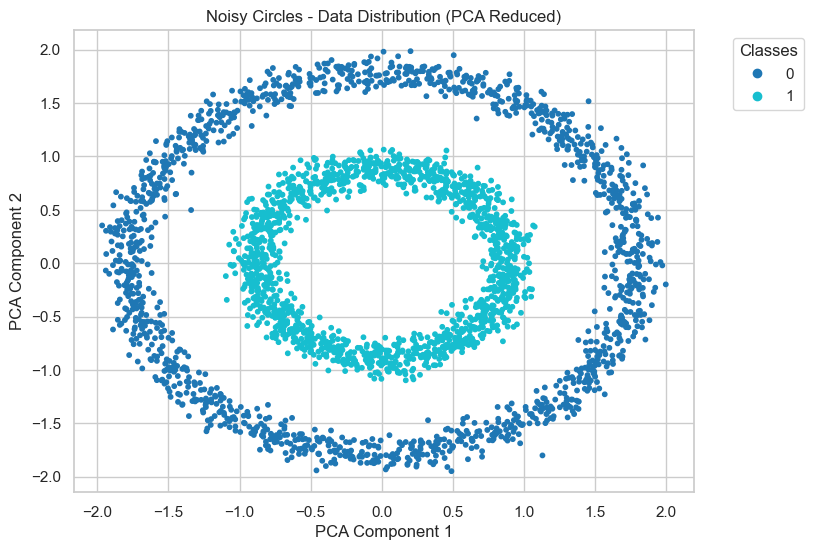

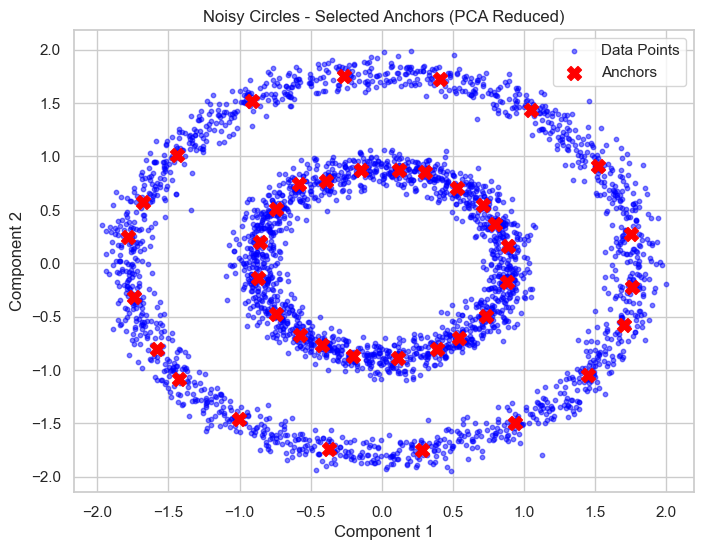

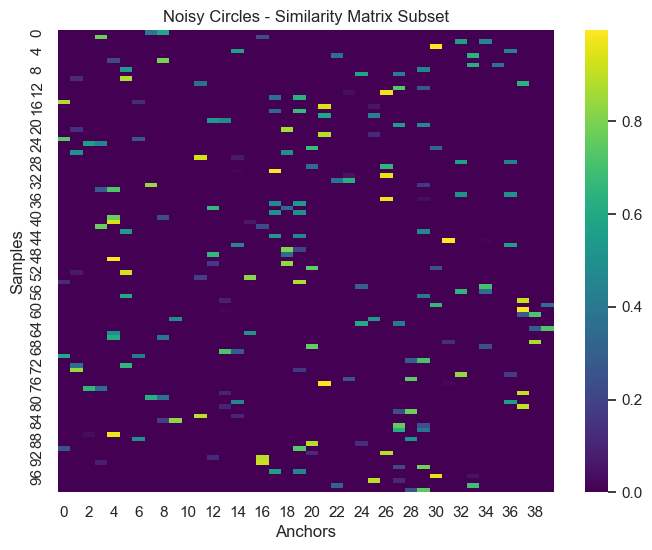

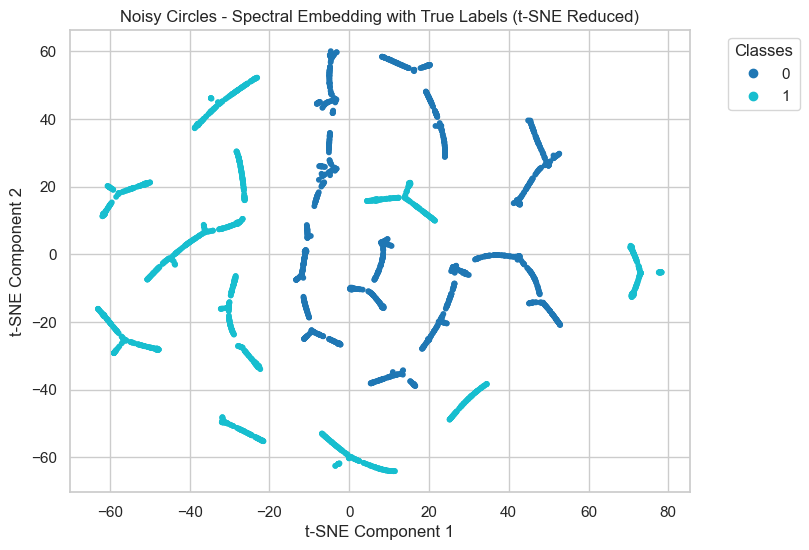

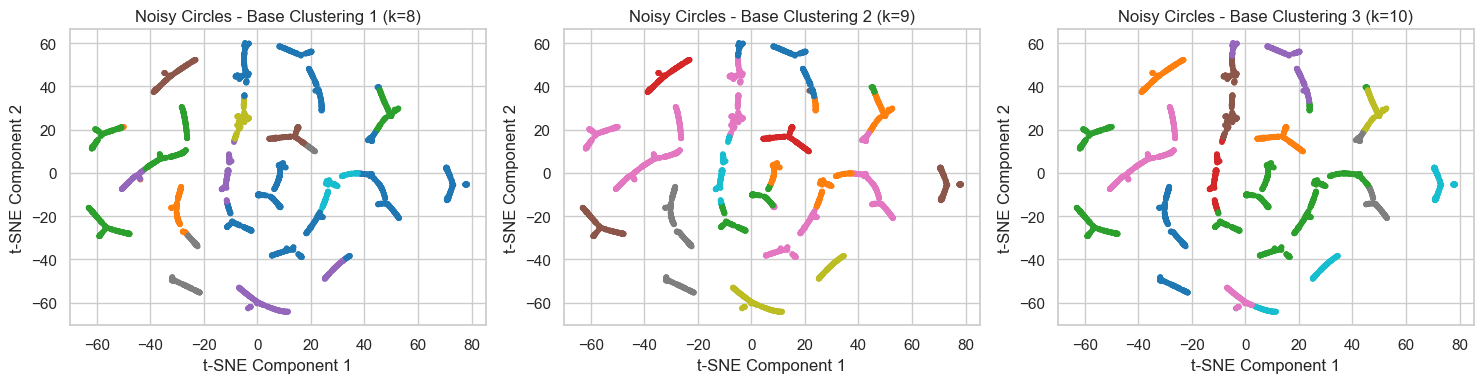

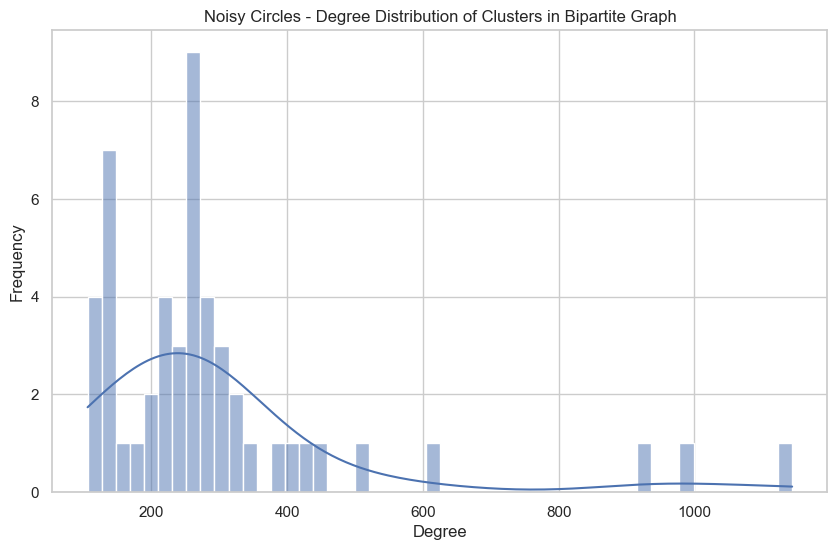

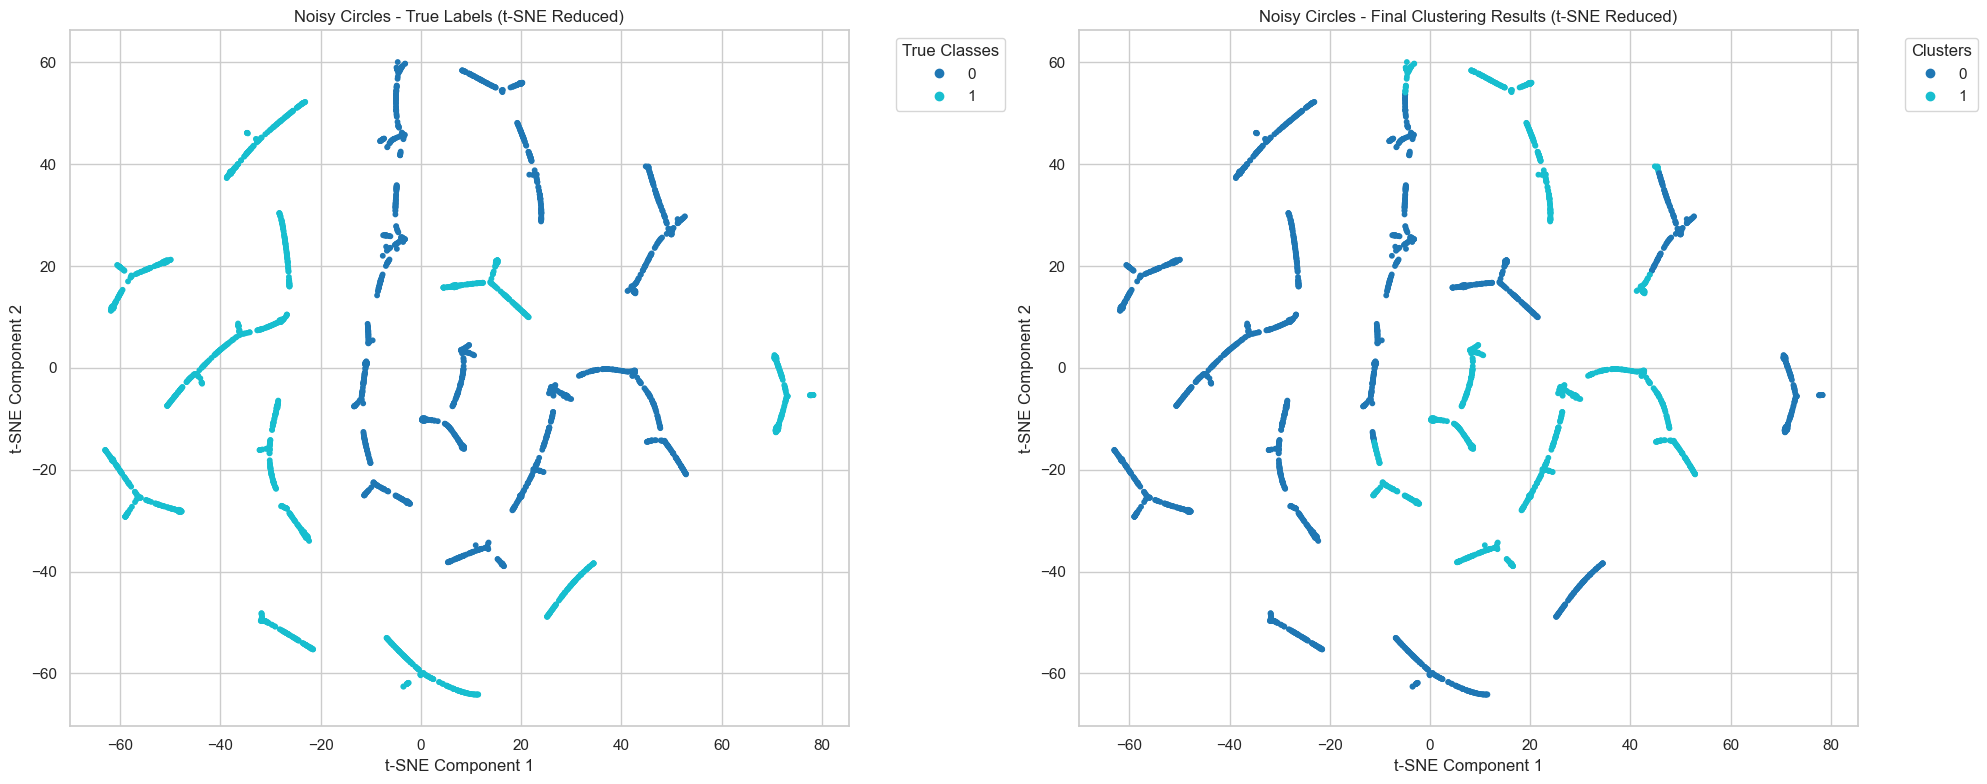

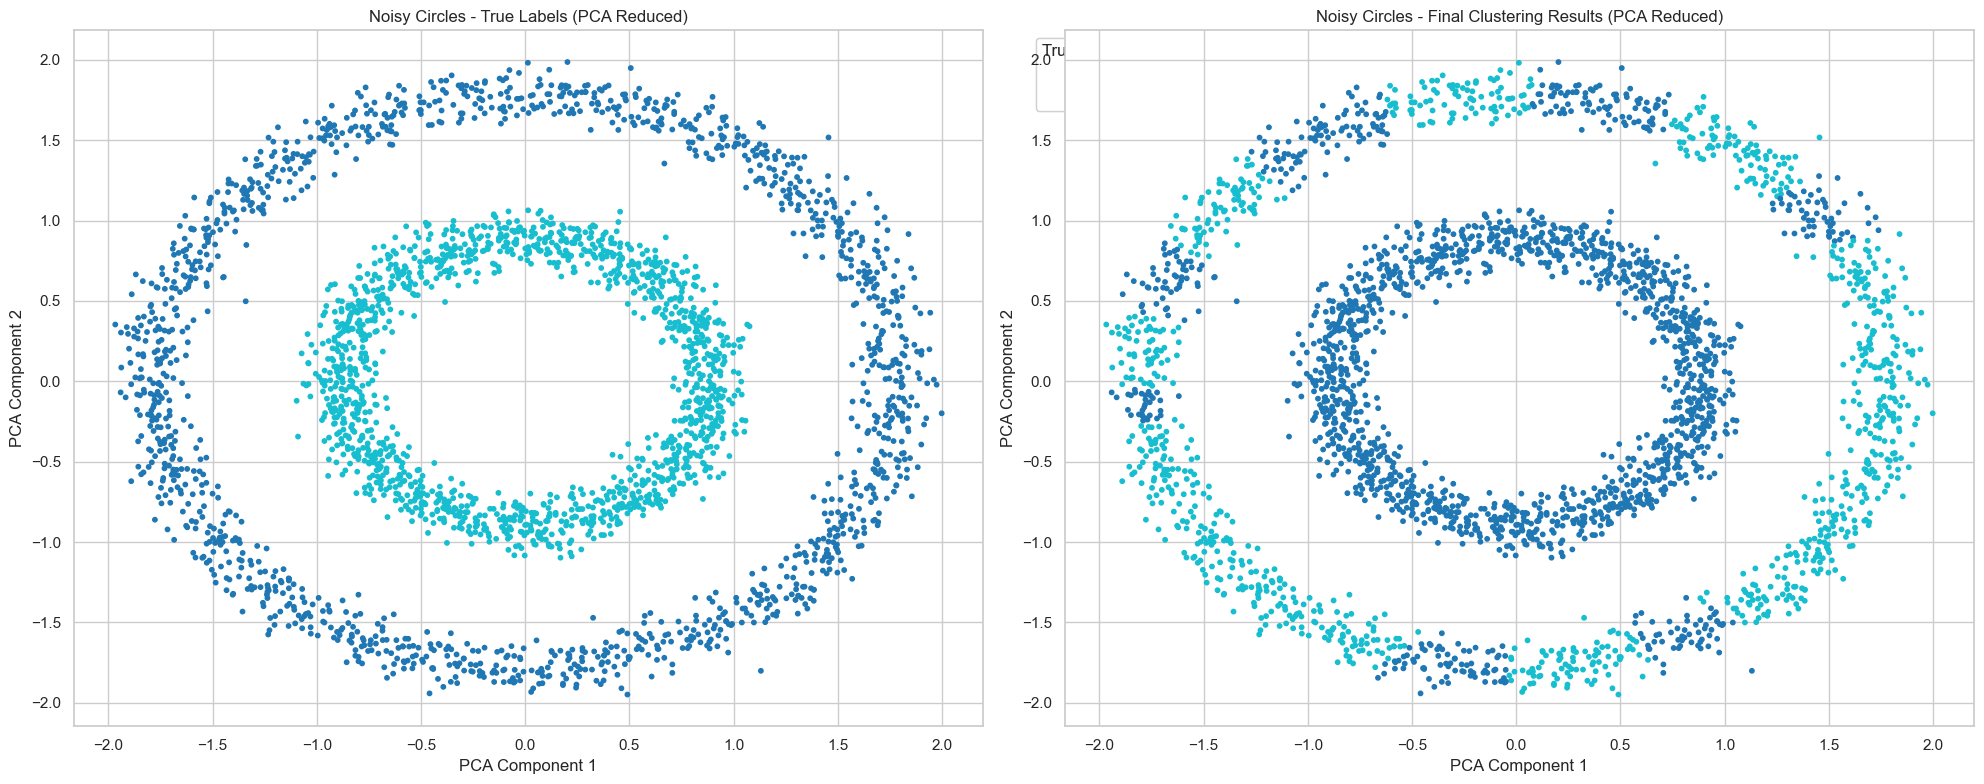

Evaluation Metrics for Noisy Circles:
  Normalized Mutual Information (NMI): 0.5025
  Adjusted Rand Index (ARI): 0.4787
  Clustering Accuracy (ACC): 0.8460

Processing Dataset: Noisy Moons


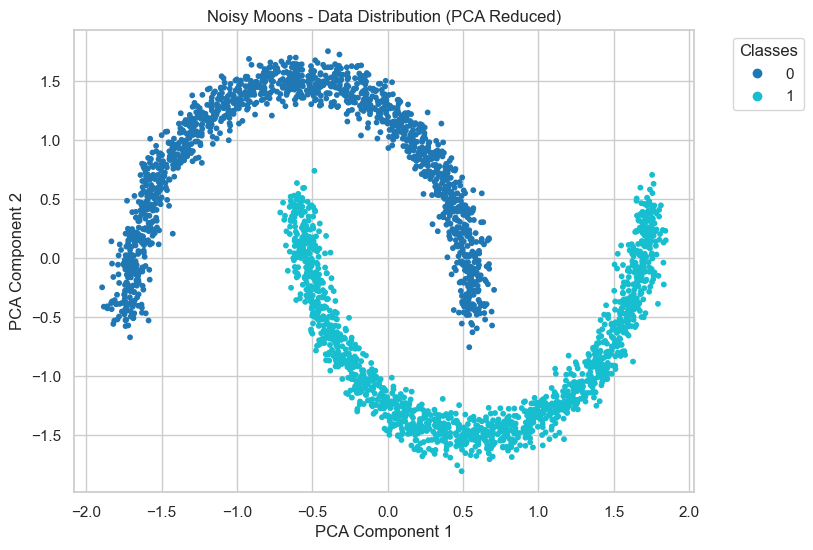

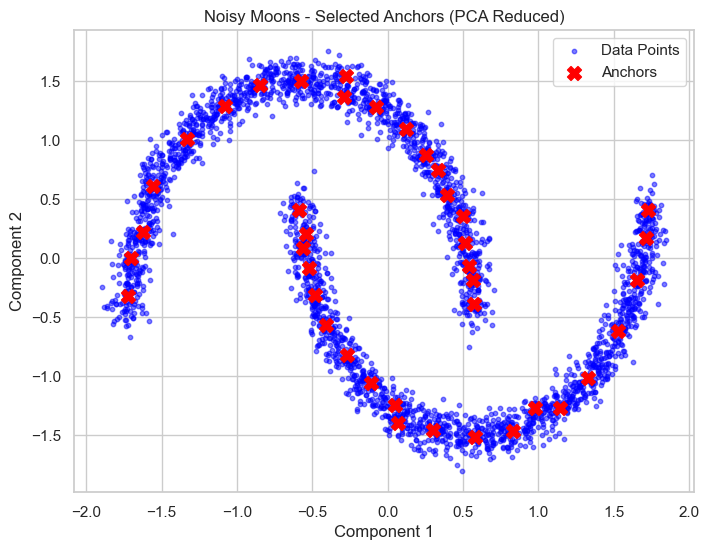

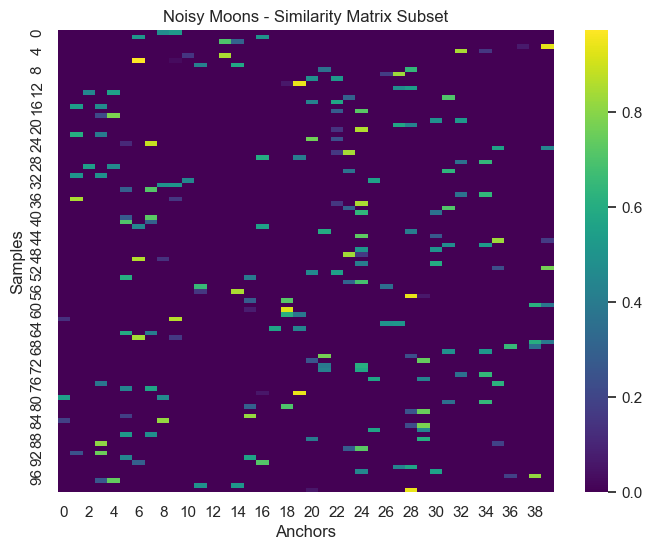

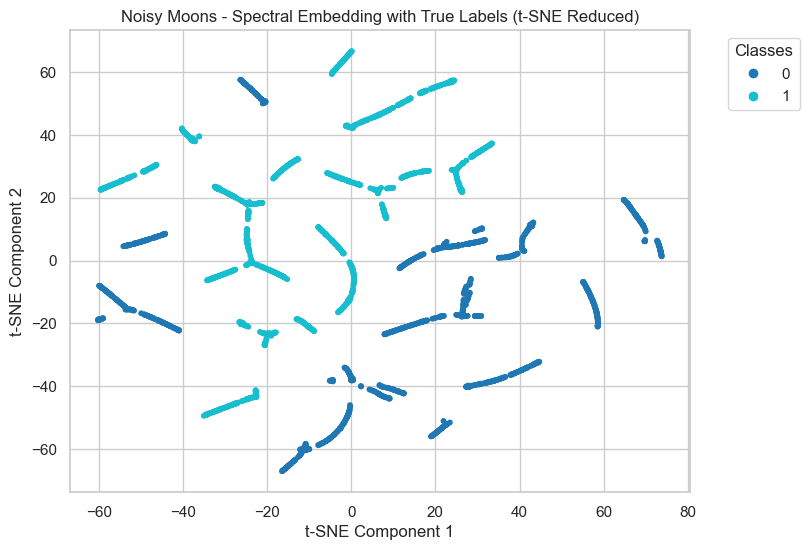

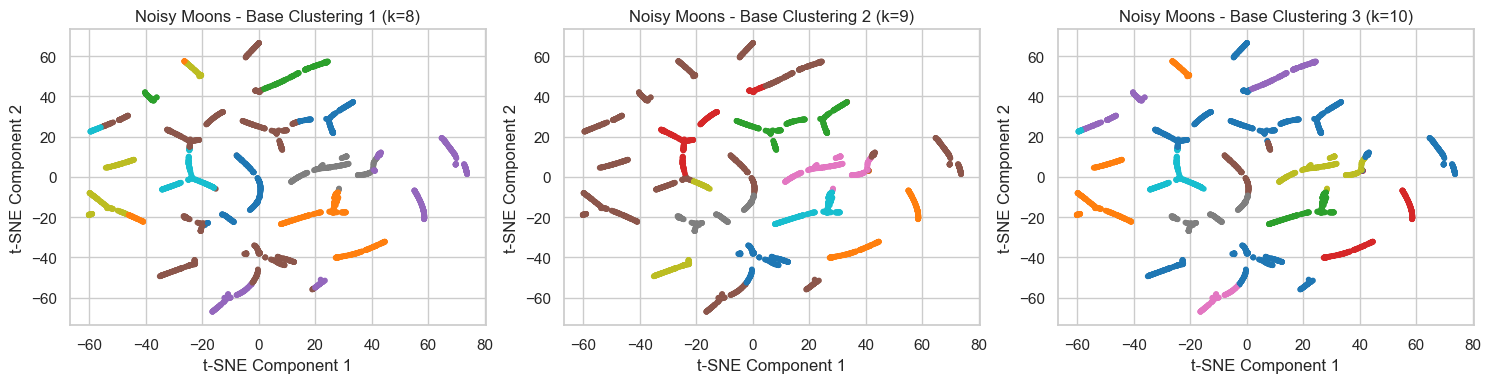

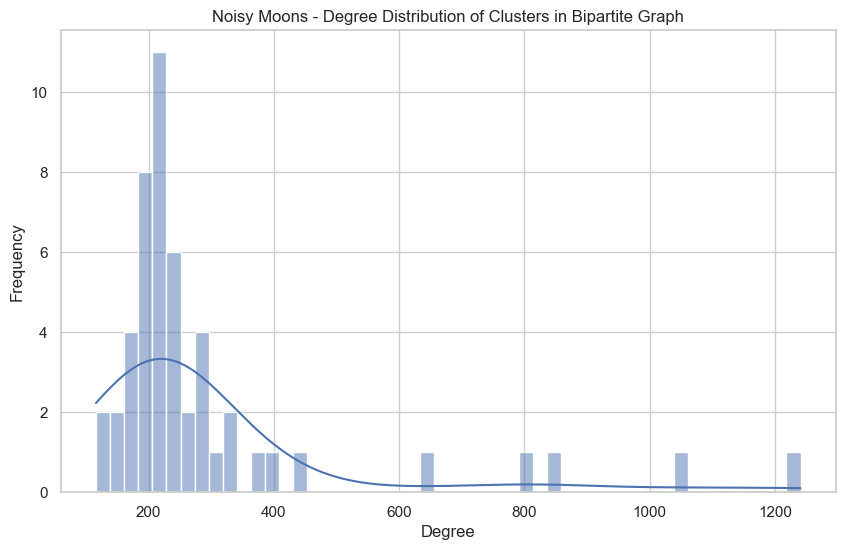

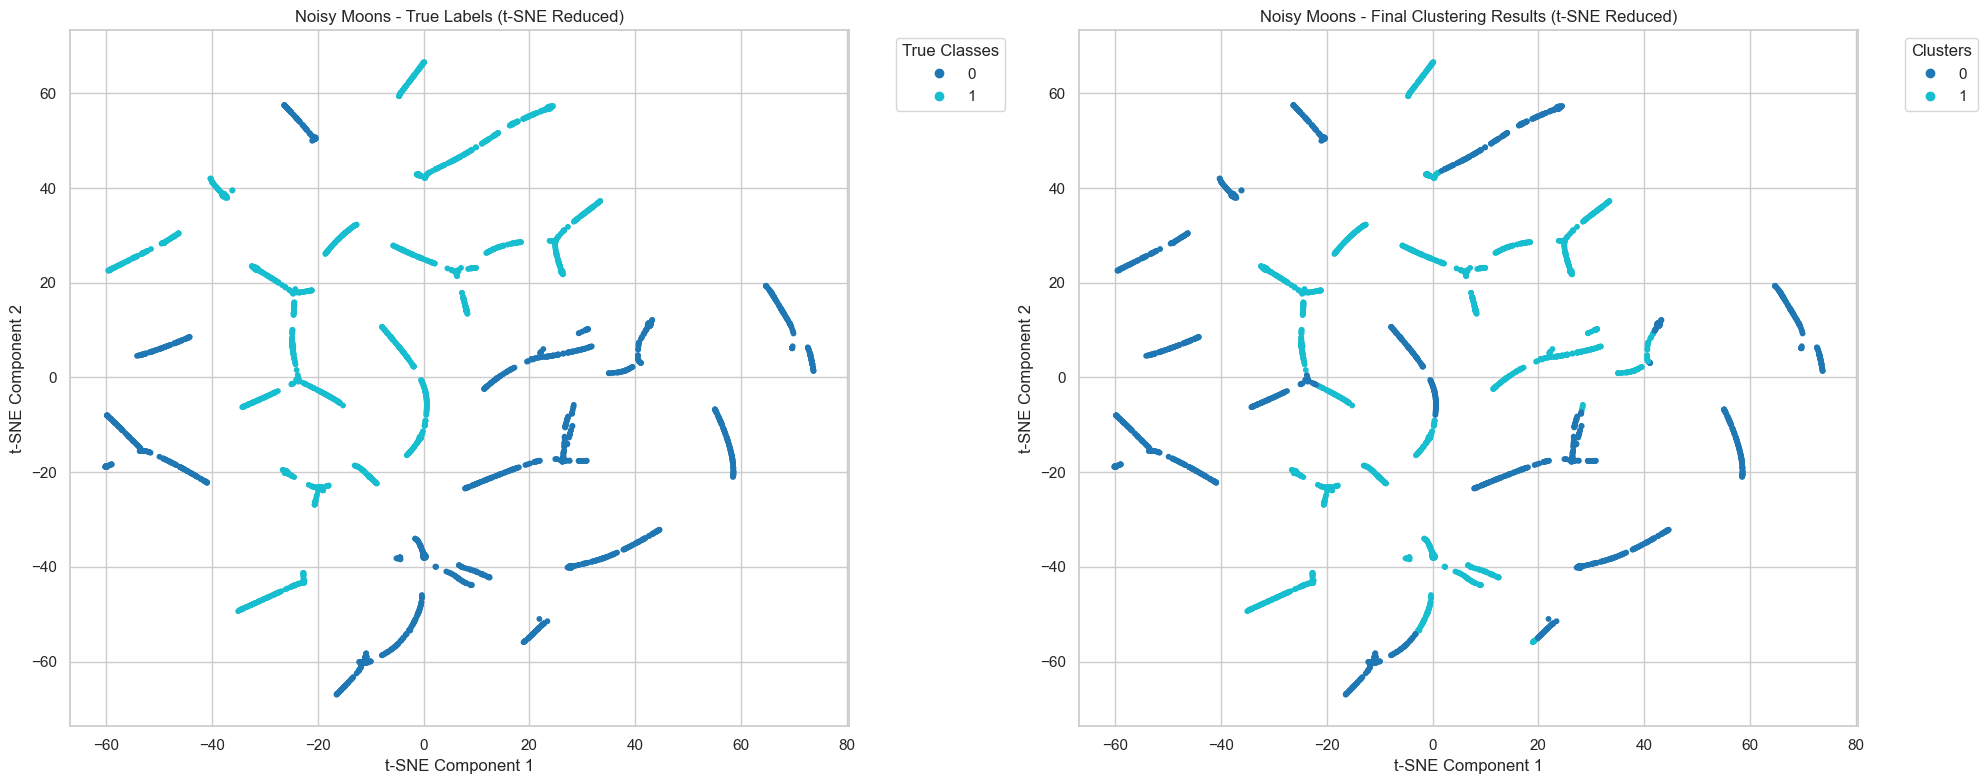

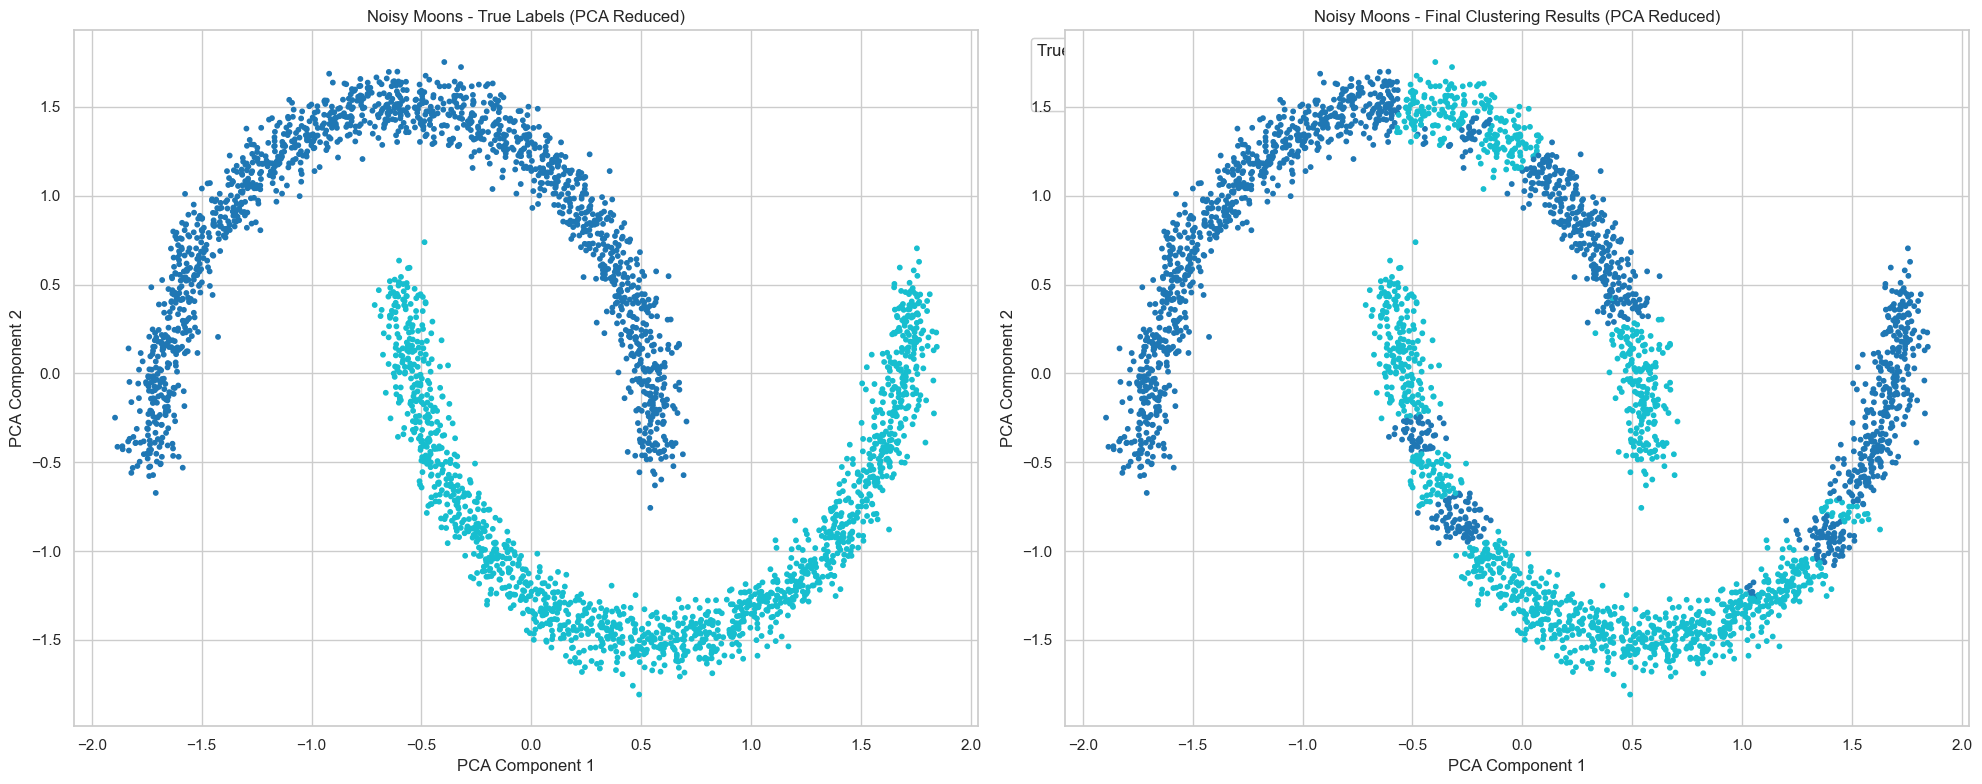

Evaluation Metrics for Noisy Moons:
  Normalized Mutual Information (NMI): 0.1072
  Adjusted Rand Index (ARI): 0.1436
  Clustering Accuracy (ACC): 0.6897

Processing Dataset: Varied Blobs


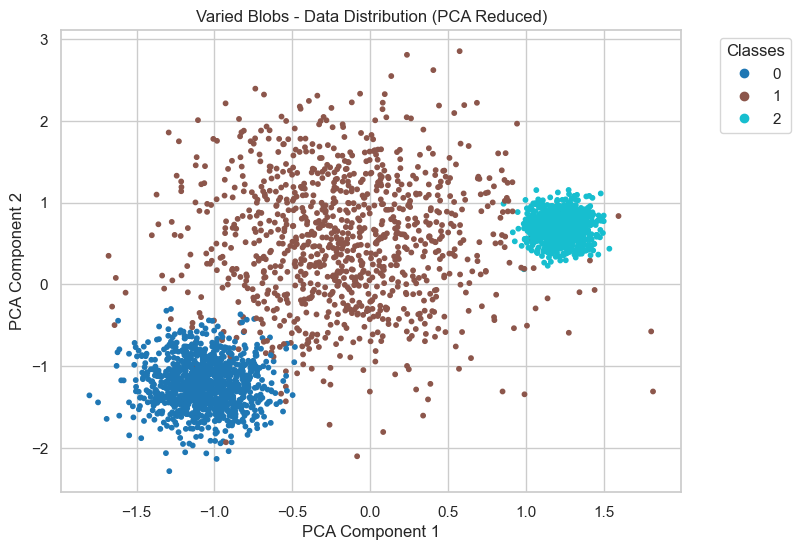

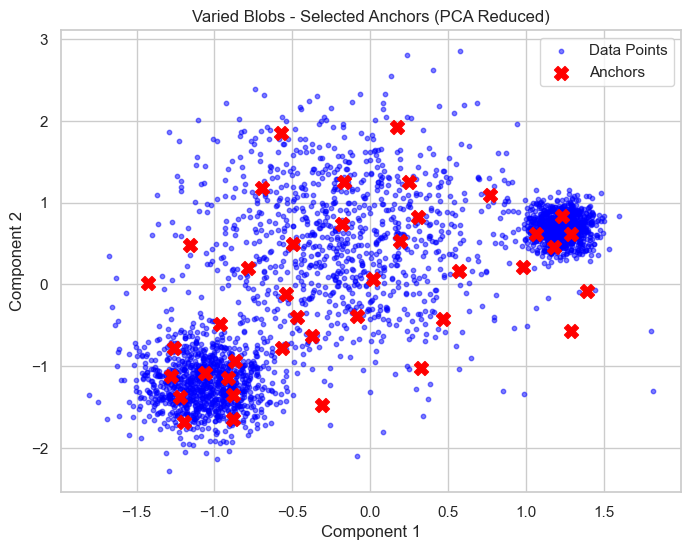

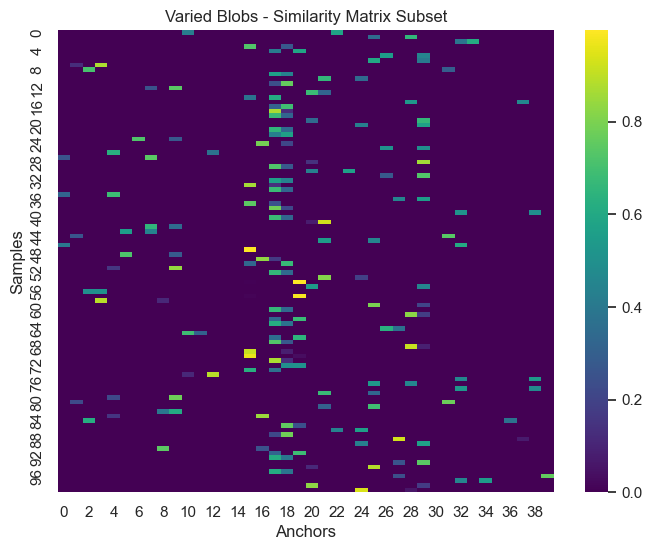

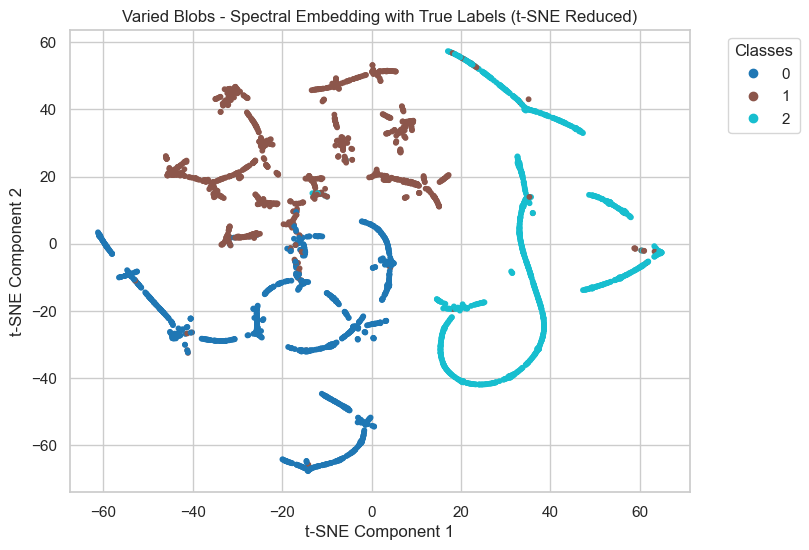

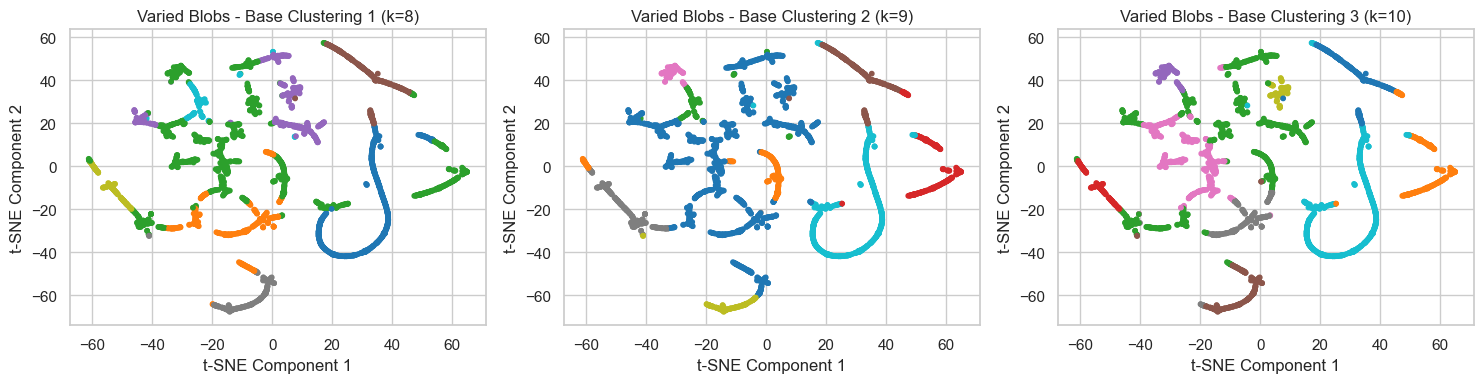

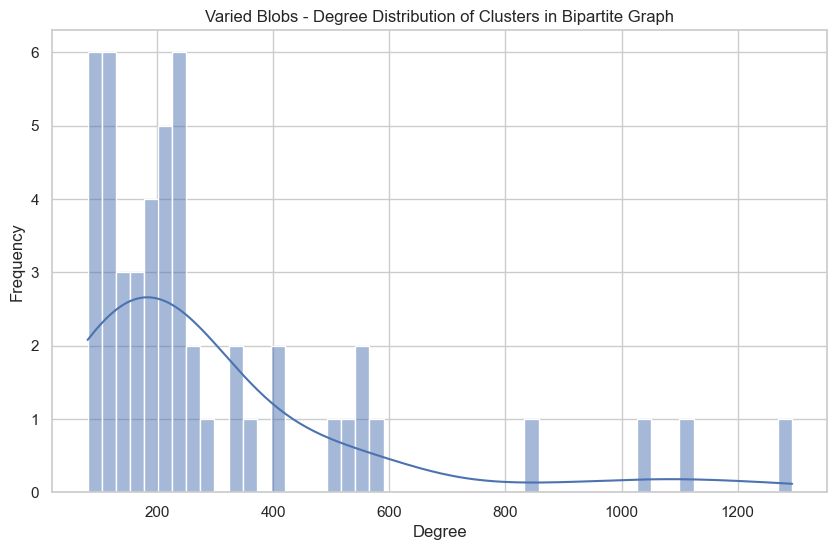

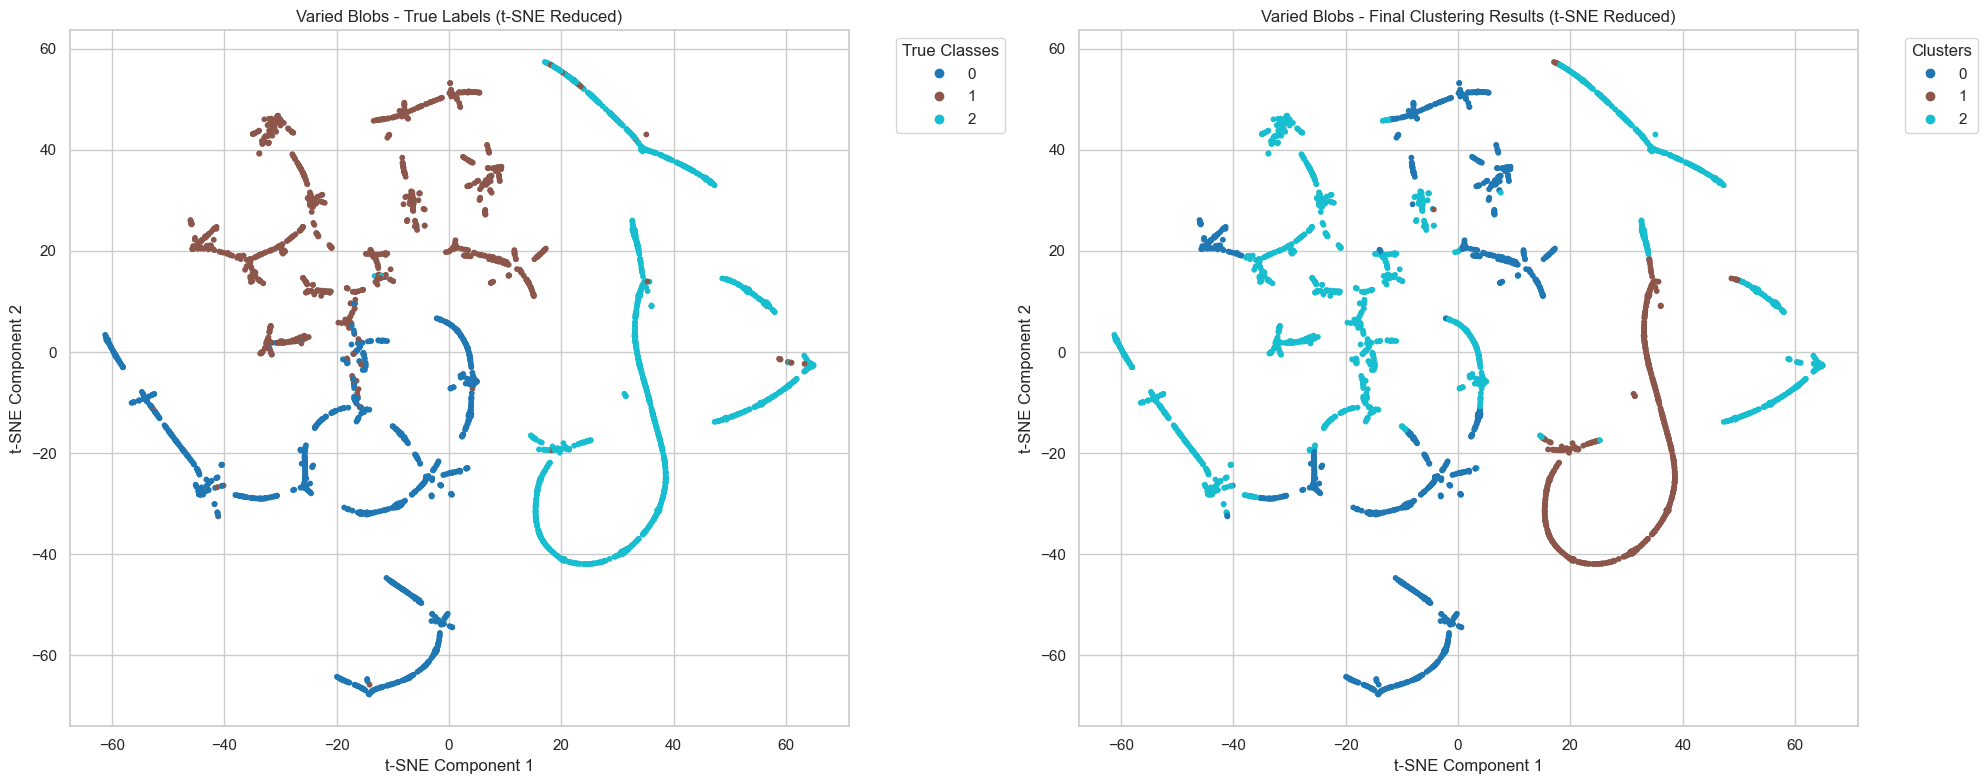

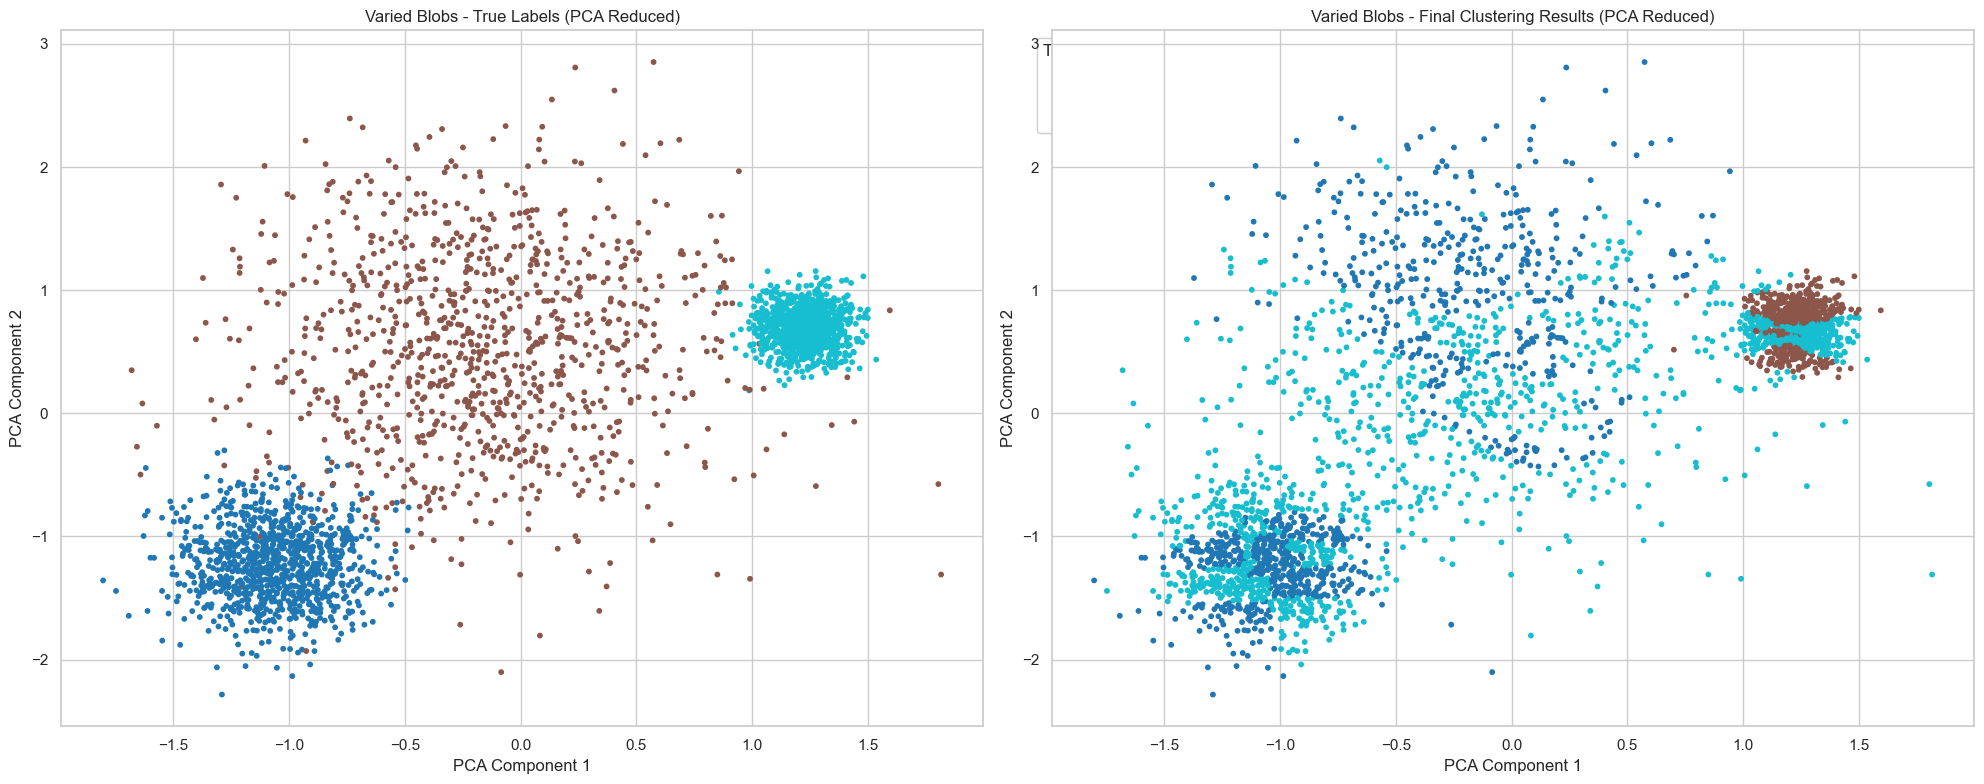

Evaluation Metrics for Varied Blobs:
  Normalized Mutual Information (NMI): 0.3067
  Adjusted Rand Index (ARI): 0.1731
  Clustering Accuracy (ACC): 0.5397

Processing Dataset: Anisotropic Blobs


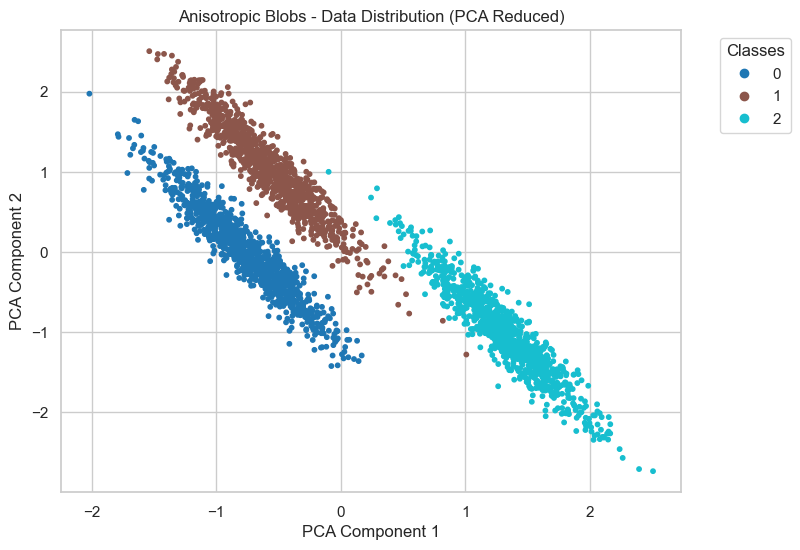

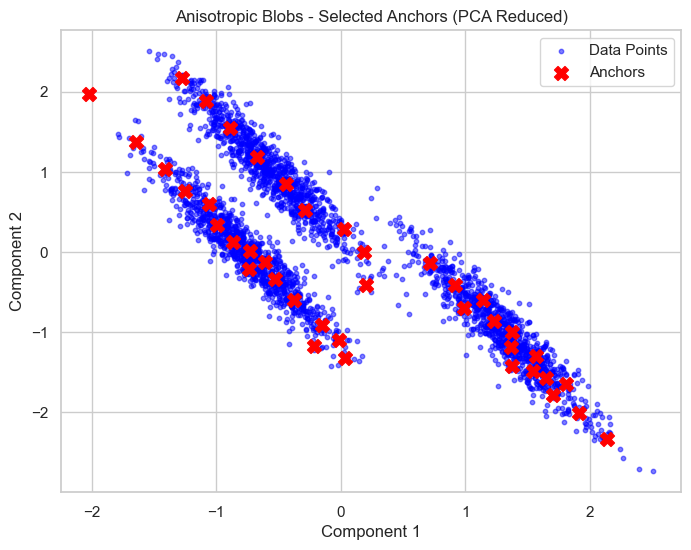

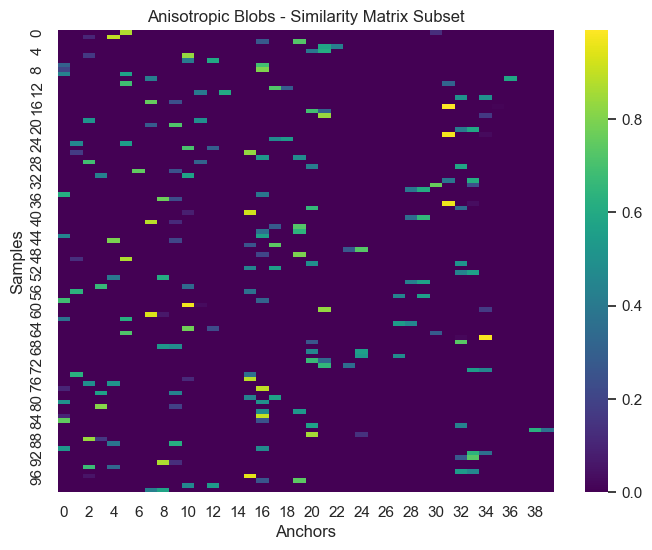

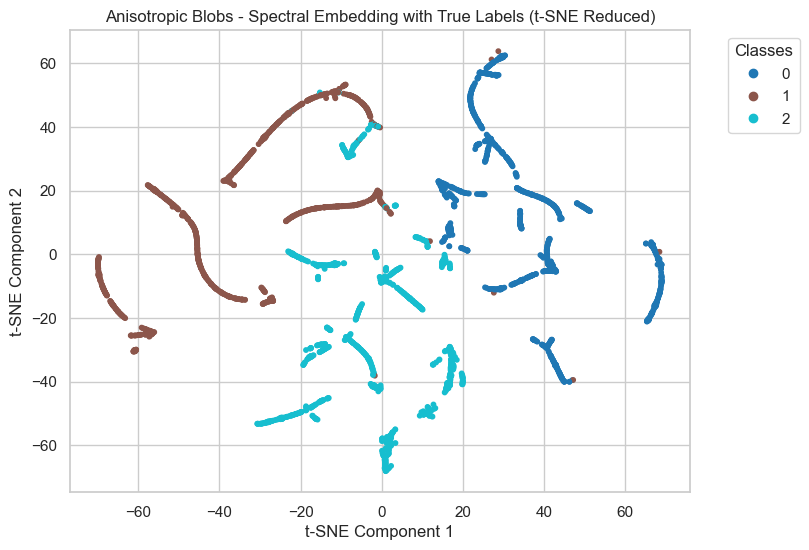

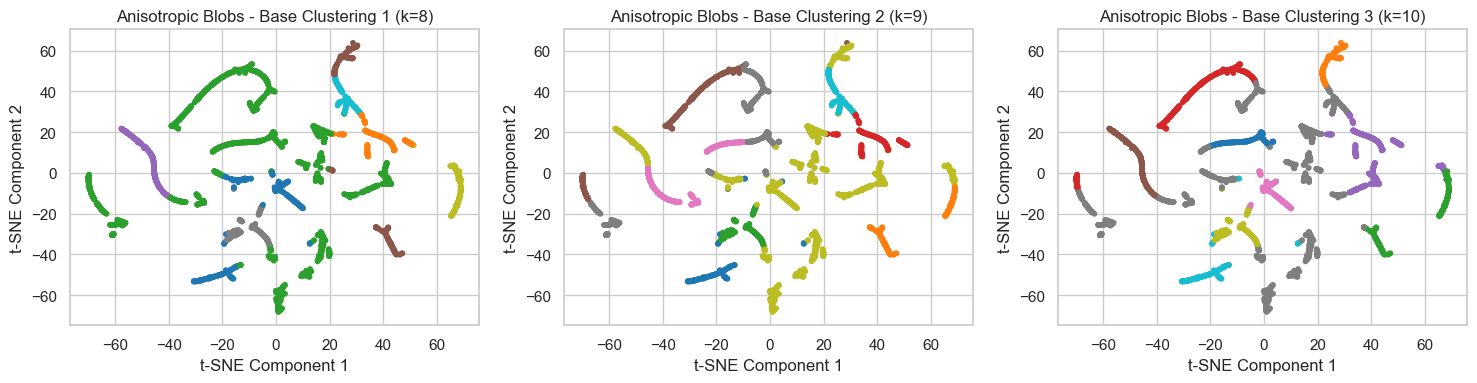

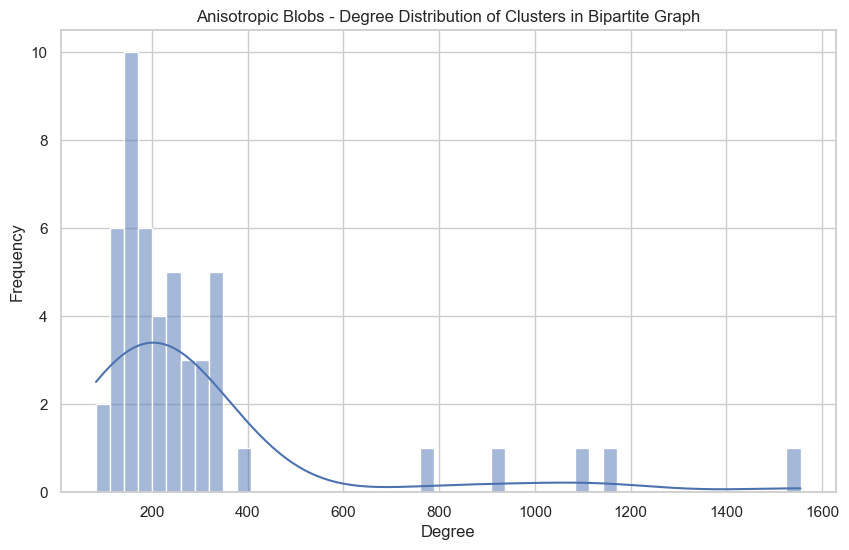

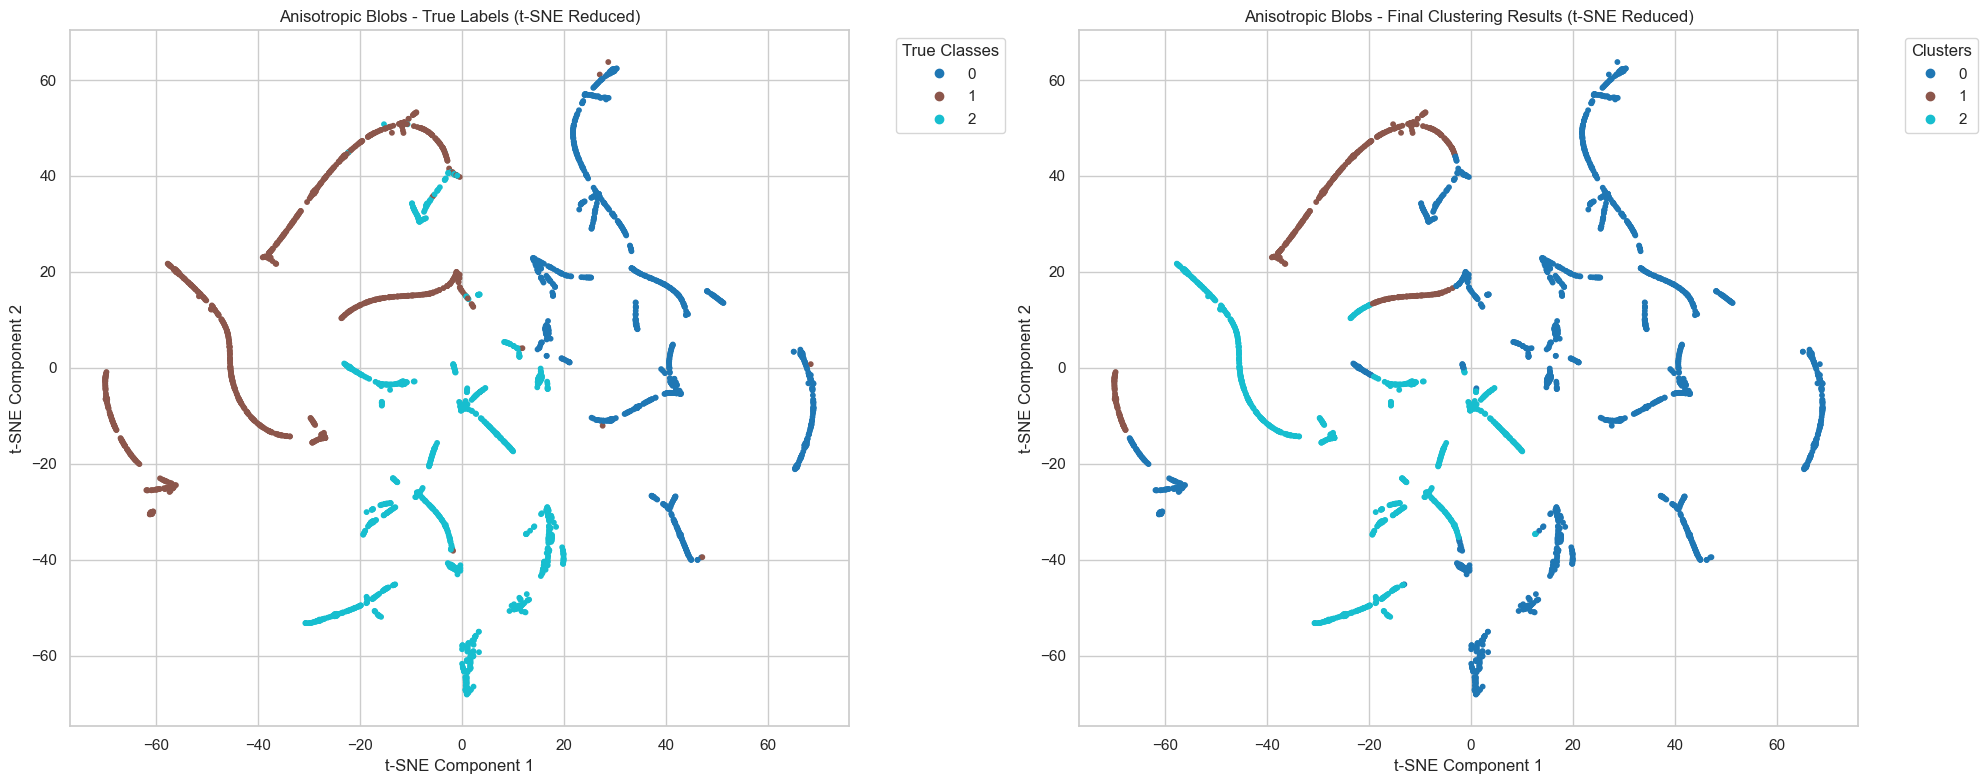

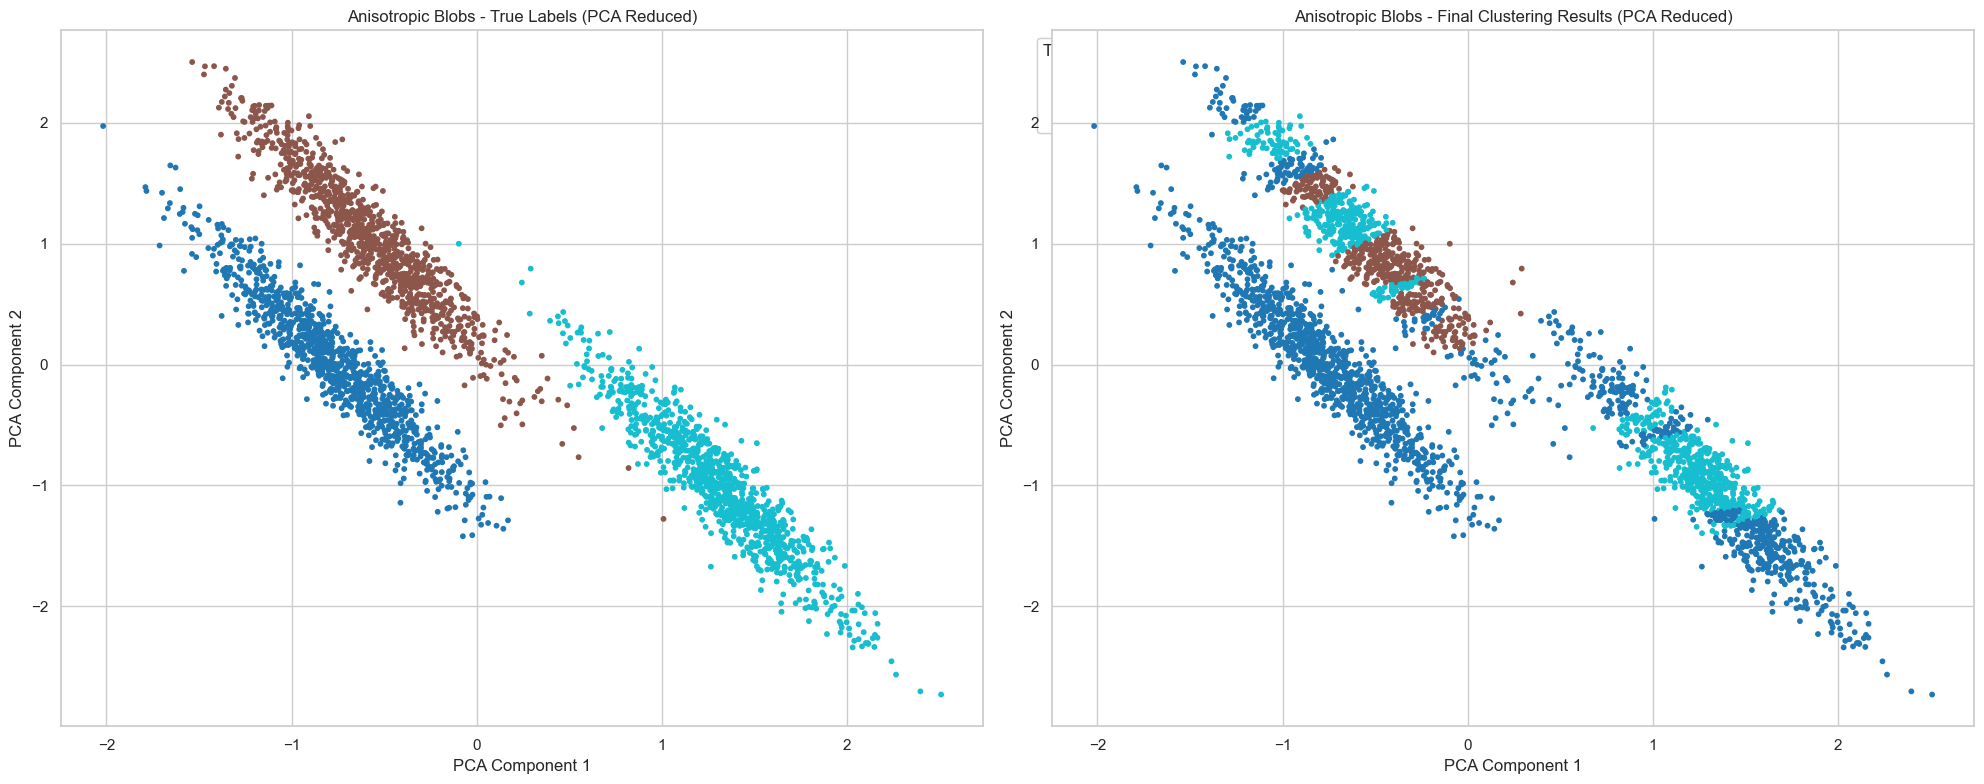

Evaluation Metrics for Anisotropic Blobs:
  Normalized Mutual Information (NMI): 0.3707
  Adjusted Rand Index (ARI): 0.2830
  Clustering Accuracy (ACC): 0.6530

Processing Dataset: Blobs


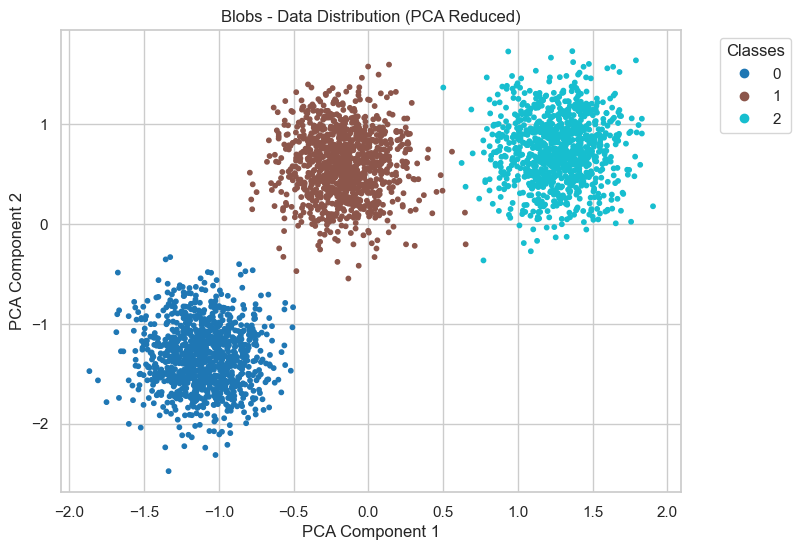

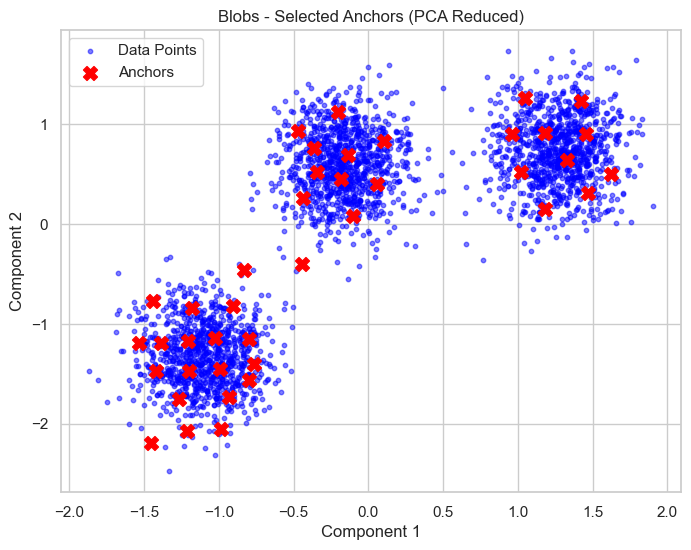

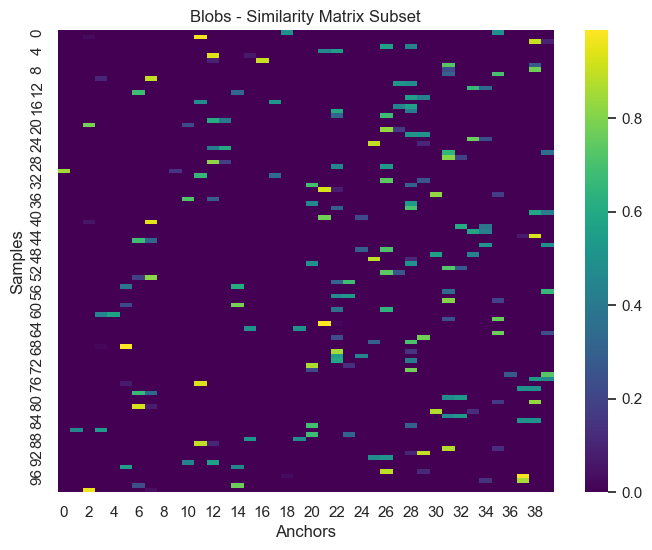

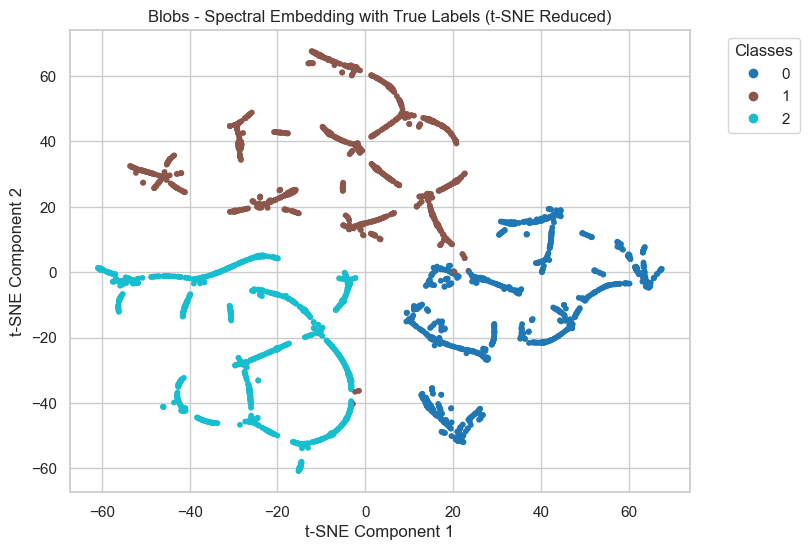

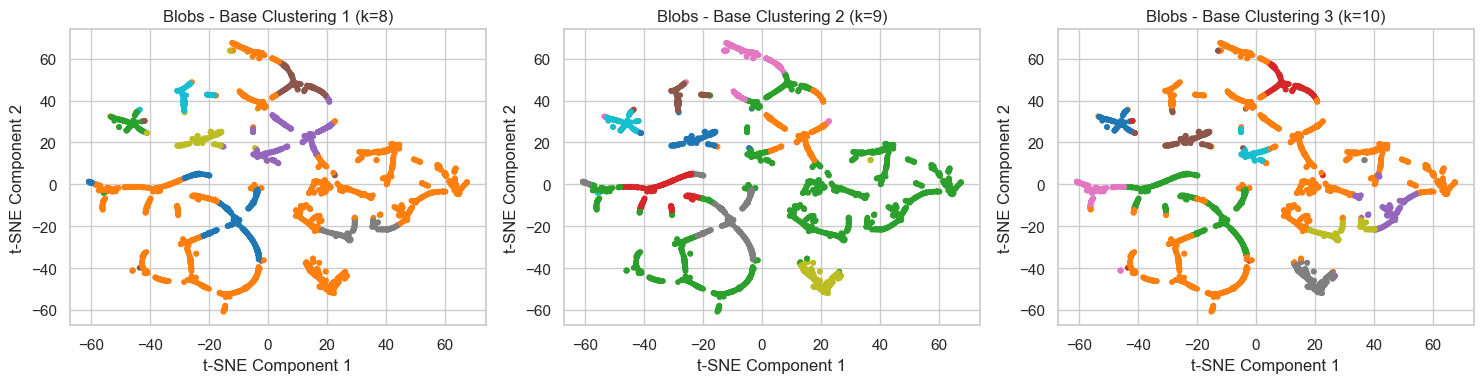

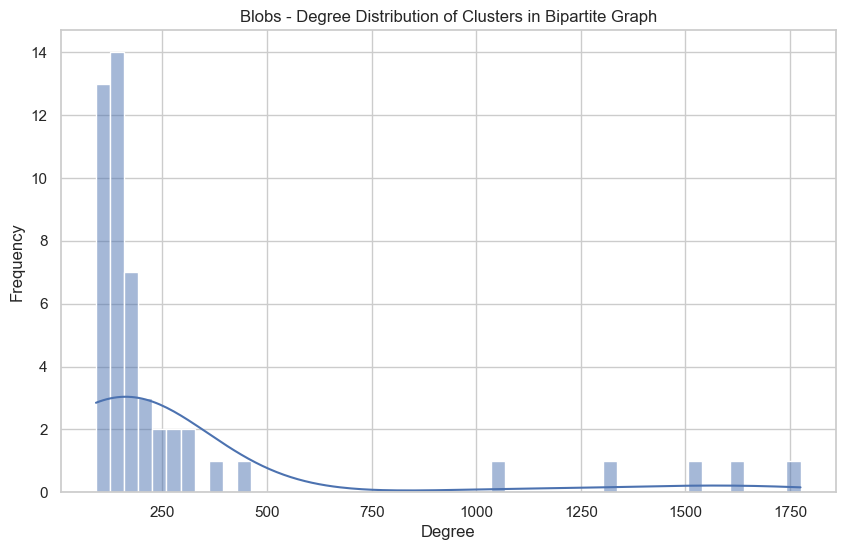

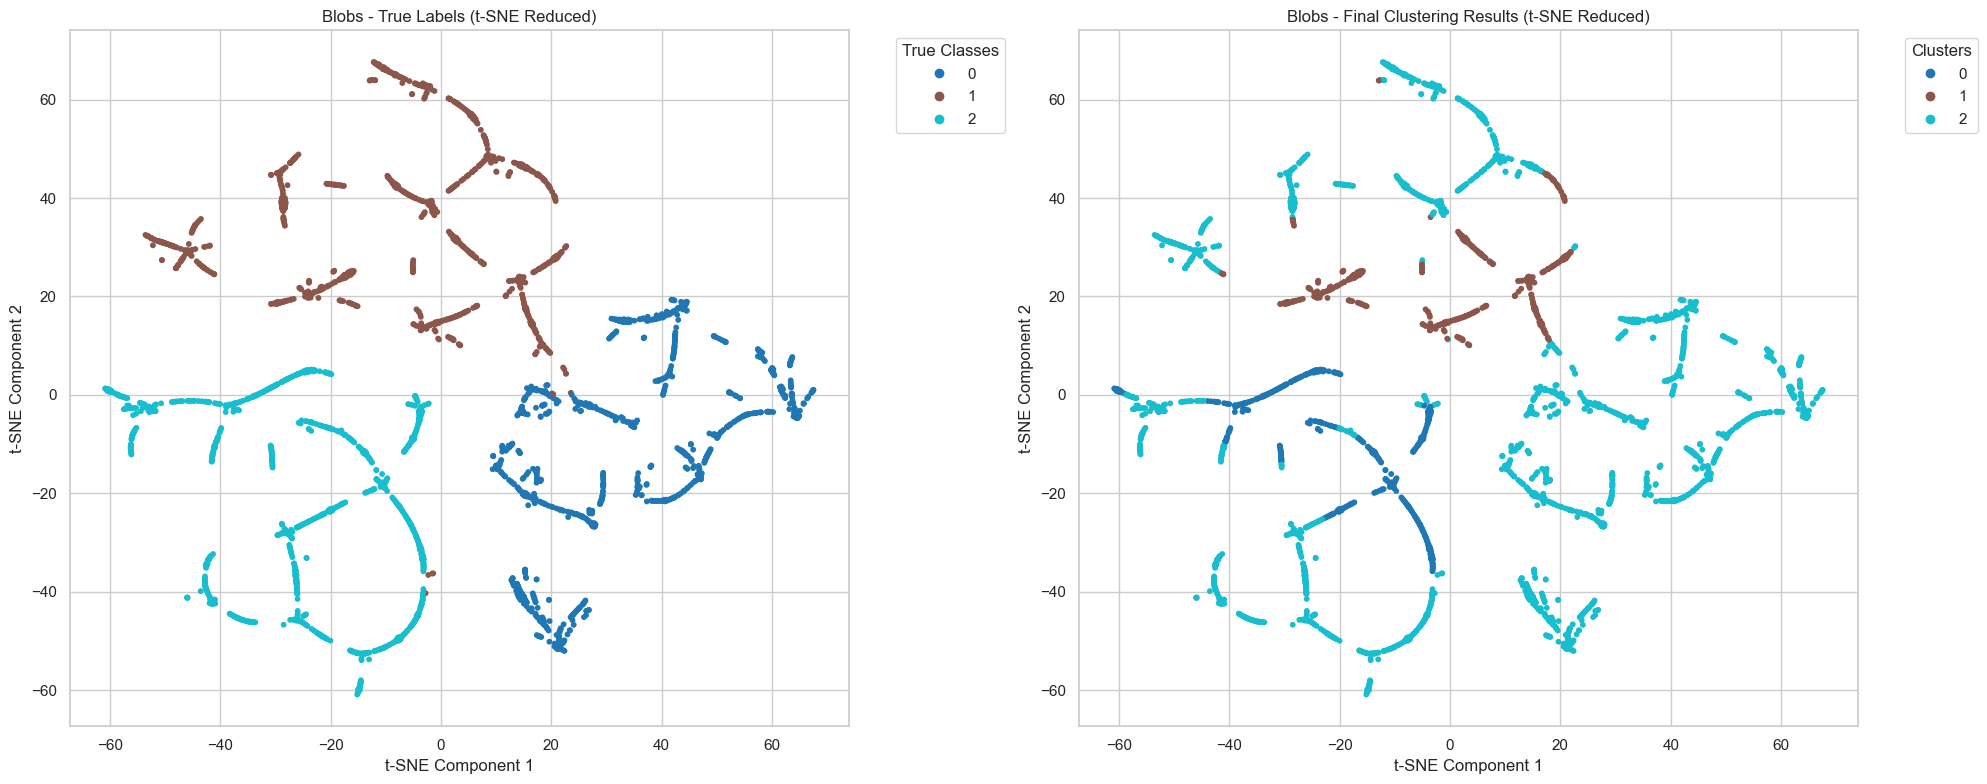

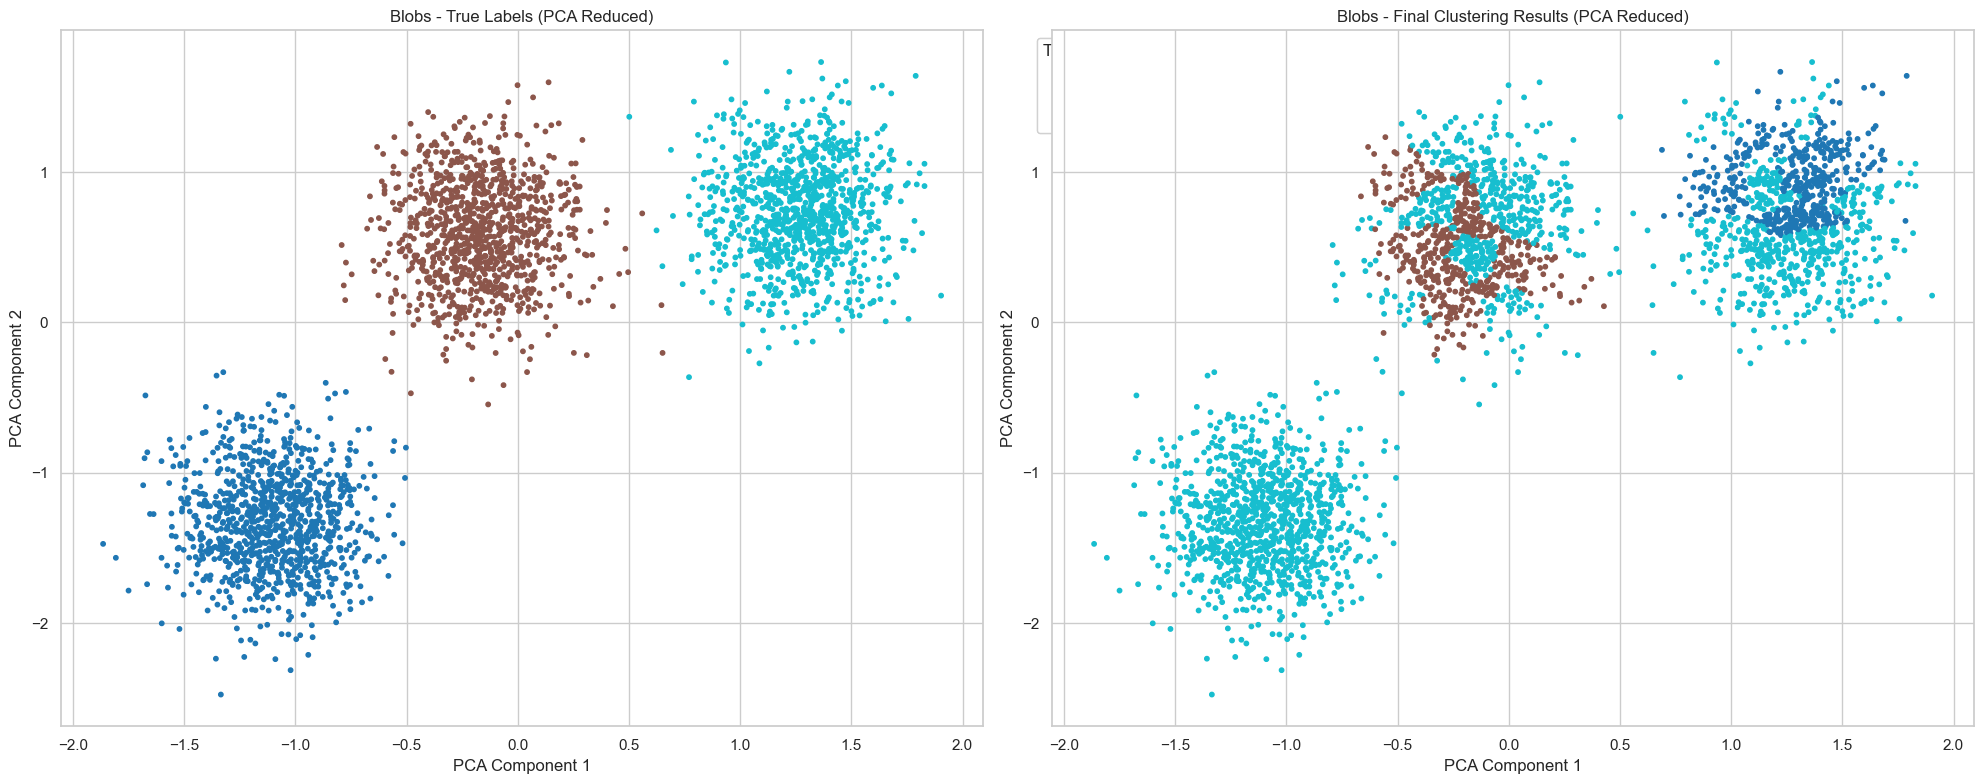

Evaluation Metrics for Blobs:
  Normalized Mutual Information (NMI): 0.3778
  Adjusted Rand Index (ARI): 0.1782
  Clustering Accuracy (ACC): 0.6353

Processing Dataset: No Structure


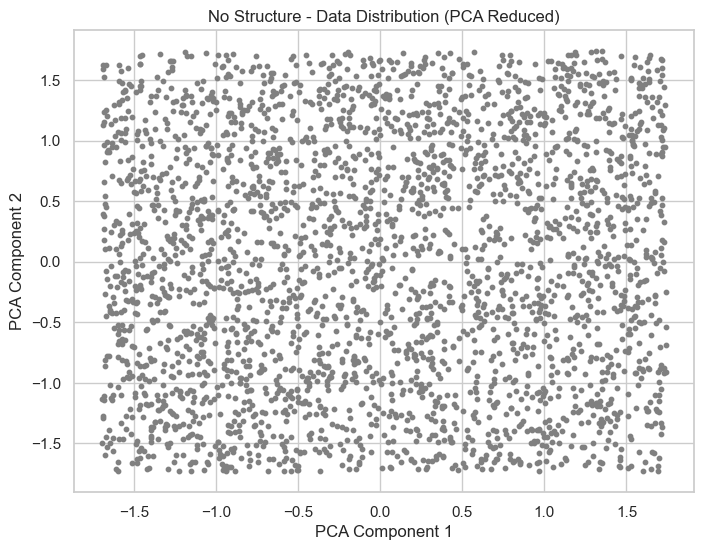

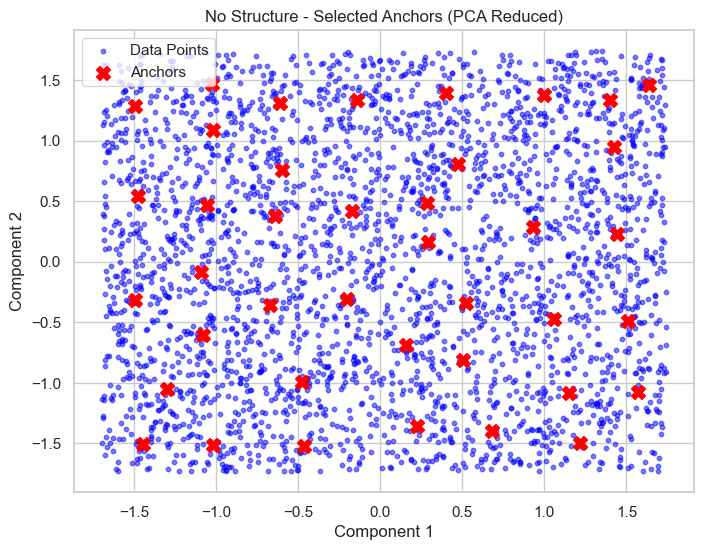

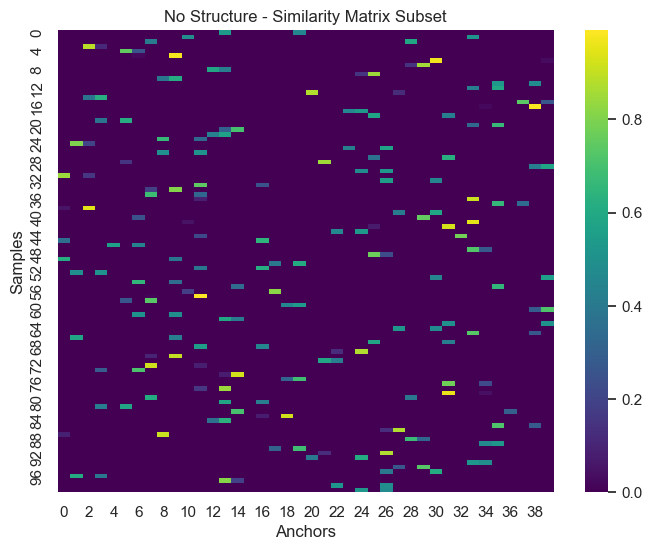

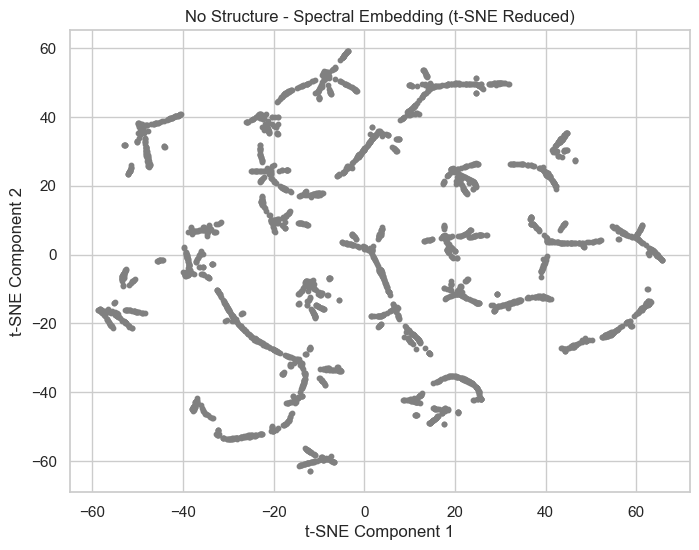

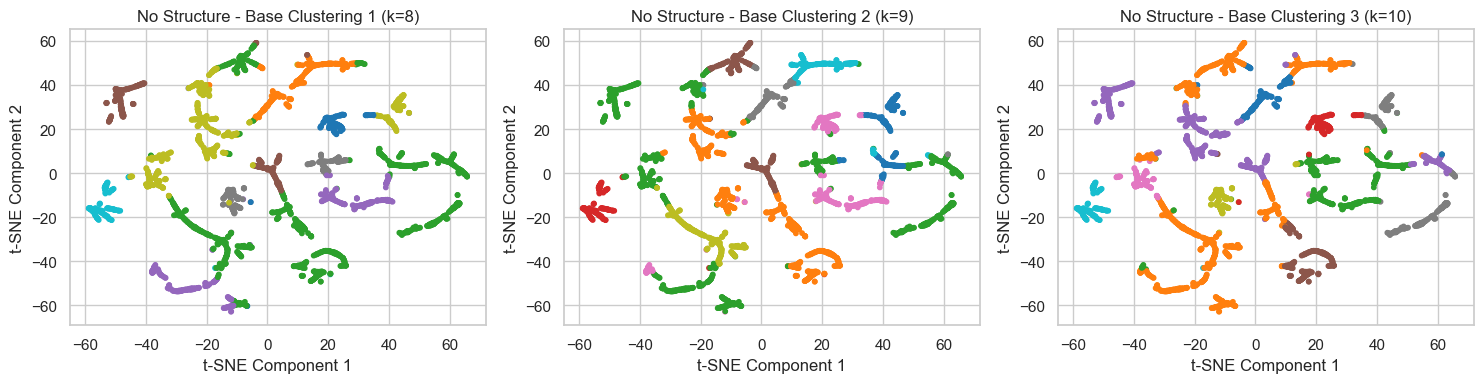

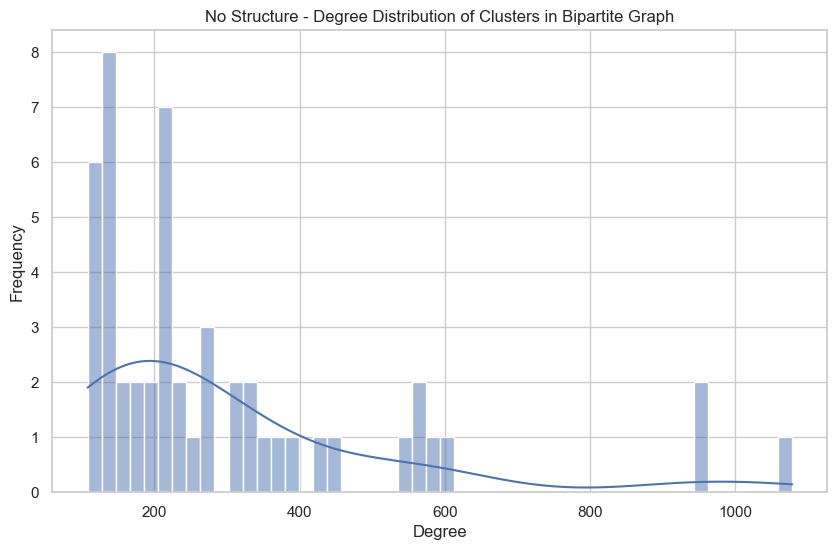

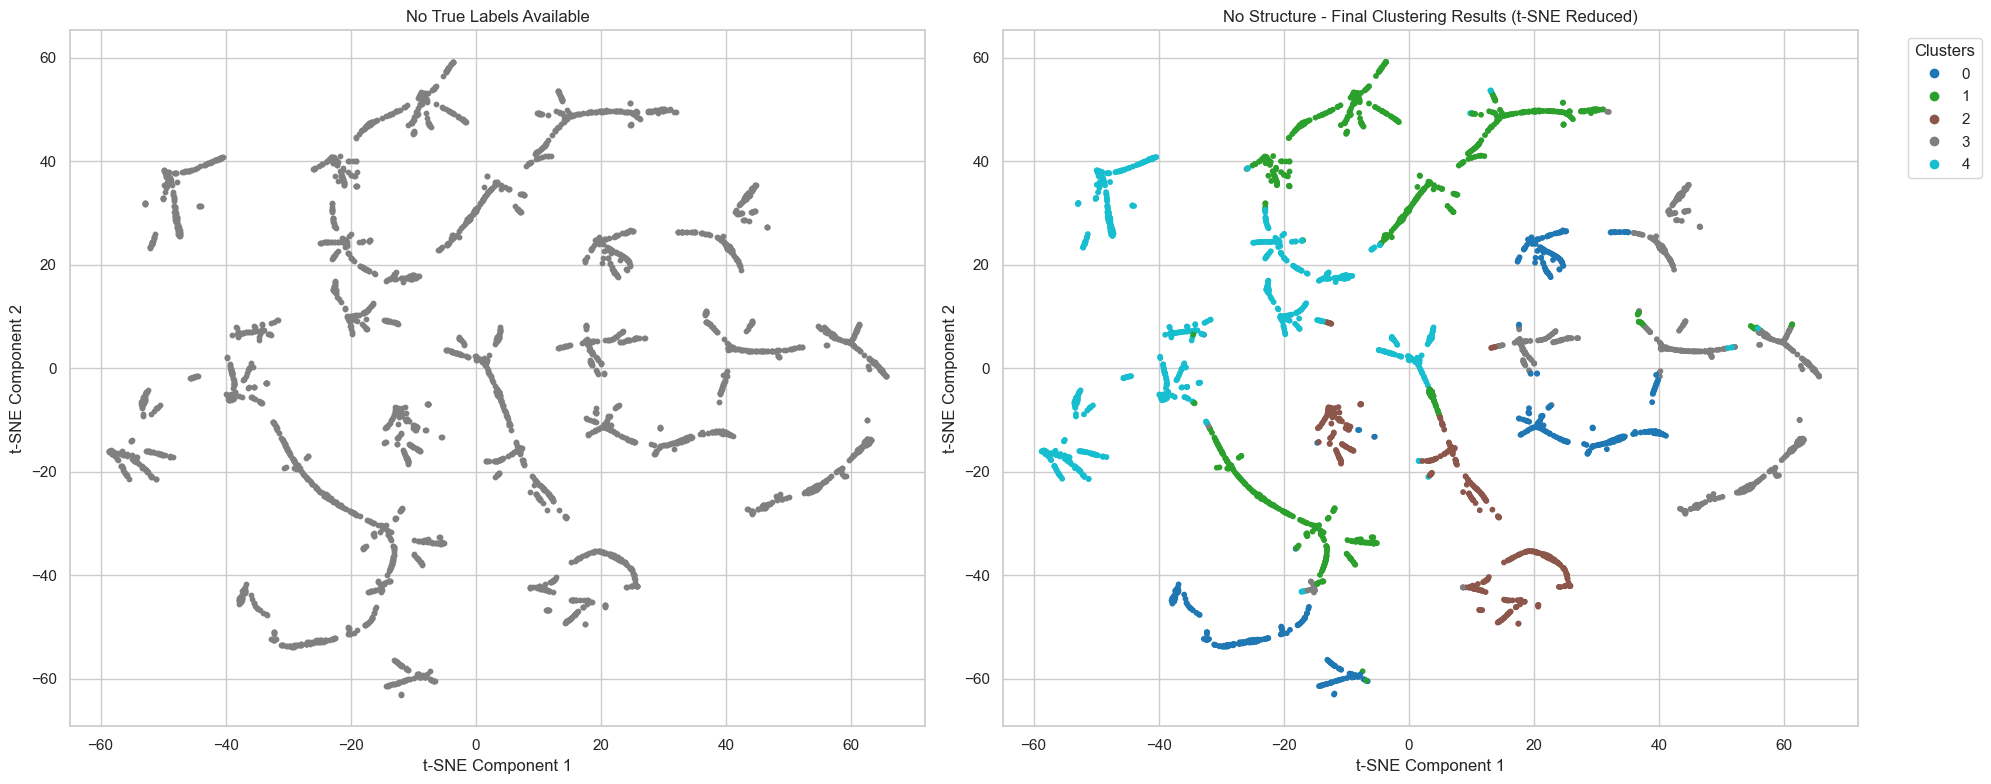

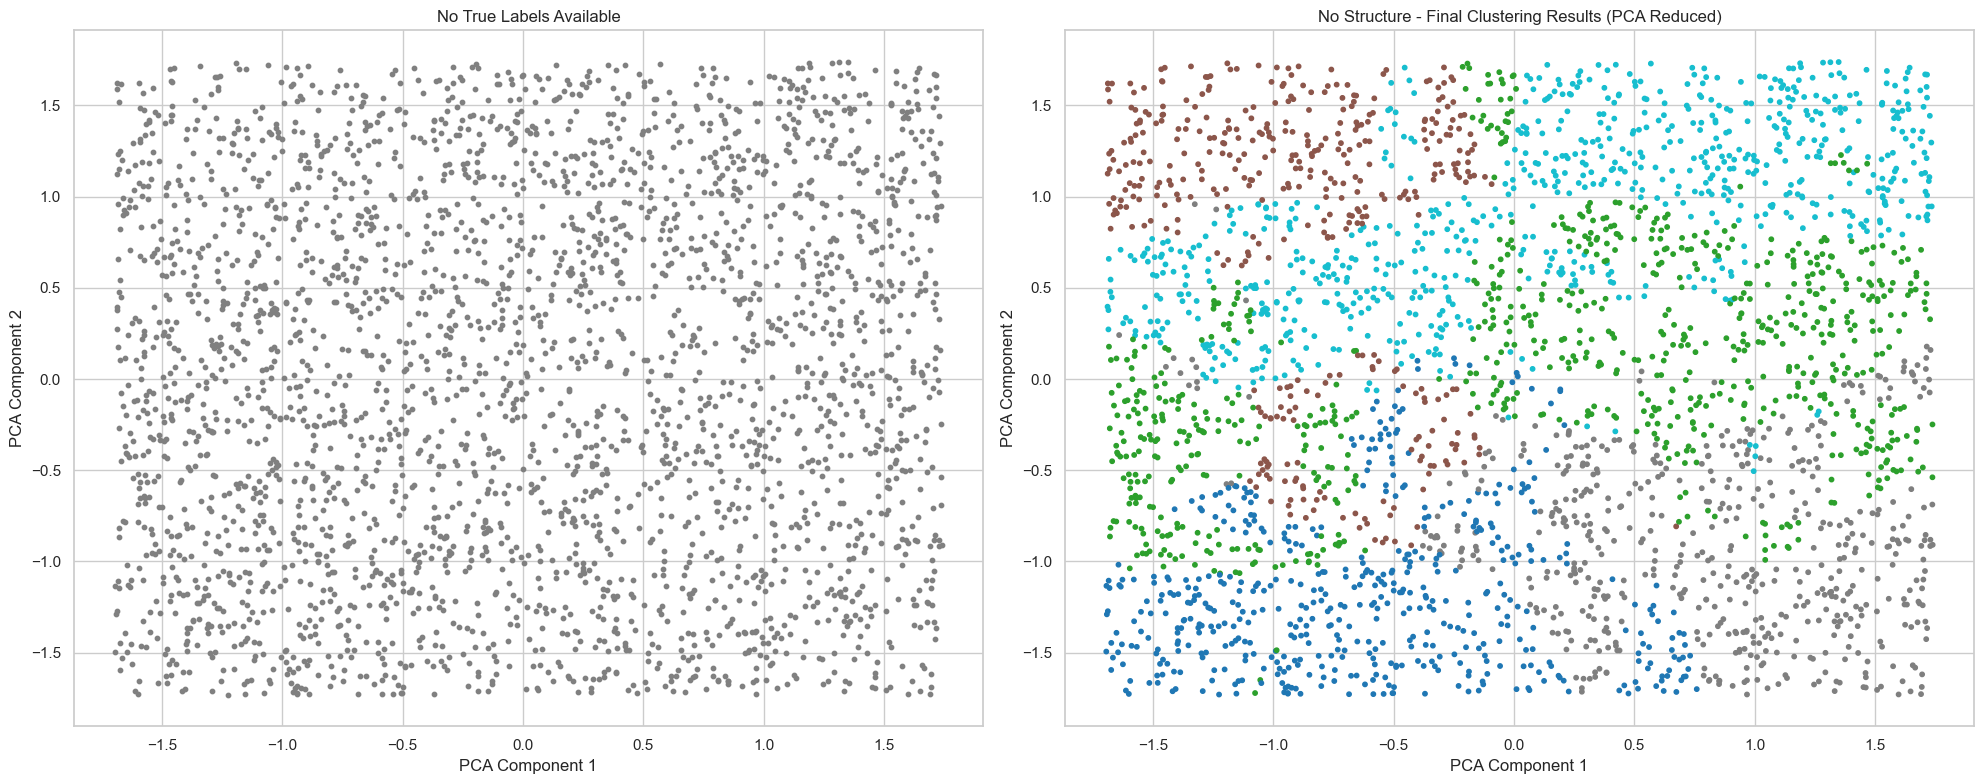

No true labels available for No Structure. Skipping evaluation metrics.


In [496]:
# Generate 2D datasets with specified number of clusters
datasets_list = generate_2d_datasets()

results = {}

for dataset_name, dataset, algo_params in datasets_list:
    result = apply_fsec_pipeline(
        dataset_name=dataset_name,
        dataset=dataset,
        algo_params=algo_params,
        num_anchors=40,
        K_prime=13,
        K=2,
        n_components=20,
        num_clusters_list=[8, 9, 10, 11, 12],
        visualize=True
    )
    results[dataset_name] = result


In [497]:
def fsec_pipeline_for_optuna(X_scaled, y, num_anchors, K_prime, K, n_components, num_clusters_list, final_n_clusters):
    # Anchor Selection
    anchors, anchor_assignments = BKHK(X_scaled, num_anchors)
    
    # Compute Anchor Neighbors
    anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)
    
    # Compute Sample-Anchor Similarities
    W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)
    
    # Compute SVD
    U = compute_svd(W, n_components)
    
    # Generate Base Clusterings
    base_clusterings = generate_base_clusterings(U, num_clusters_list)
    
    # Build Bipartite Graph
    H = build_bipartite_graph(base_clusterings)
    
    # Consensus Clustering
    final_labels = consensus_clustering(H, n_clusters=final_n_clusters)
    
    # Evaluation Metrics
    nmi = normalized_mutual_info_score(y, final_labels)
    
    return nmi


In [498]:
def optimize_fsec(X_scaled, y, num_clusters_list=[8,9,10,11,12], final_n_clusters=10, n_trials=50):
    def objective(trial):
        num_anchors = trial.suggest_int('num_anchors', 25, 100)
        K_prime = trial.suggest_int('K_prime', 2, 15)
        K = trial.suggest_int('K', 1, 15)
        n_components = trial.suggest_int('n_components', 10, 50)
        
        # Ensure constraints
        if num_anchors < n_components:
            return 0.0
        if K_prime <= K:
            return 0.0
        
        try:
            nmi = fsec_pipeline_for_optuna(
                X_scaled, y,
                num_anchors=num_anchors,
                K_prime=K_prime,
                K=K,
                n_components=n_components,
                num_clusters_list=num_clusters_list,
                final_n_clusters=final_n_clusters
            )
        except Exception as e:
            print(f"Exception during optimization: {e}")
            return 0.0
        
        return nmi
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print(f"Best NMI: {study.best_value}")
    print(f"Best Parameters: {study.best_params}")
    
    return study.best_params, study.best_value

# Example Optimization for a specific dataset
# Choose a dataset, for example, "Noisy Circles"
dataset_name = "Noisy Circles"
dataset, y = datasets_list[0][1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[0])

best_params, best_nmi = optimize_fsec(
    X_scaled, y,
    num_clusters_list=[8,9,10,11,12],
    final_n_clusters=10,
    n_trials=50  # Adjust the number of trials as needed
)


ValueError: Expected 2D array, got 1D array instead:
array=[-1.00479824  0.33937997].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.datasets import load_digits

# Load digits dataset
digits = load_digits()
X_digits = digits.data  # Shape: (1797, 64)
y_digits = digits.target

# Normalize
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

# Apply FSEC
digits_result = apply_fsec_pipeline(
    dataset_name="Digits",
    dataset=(X_digits_scaled, y_digits),
    algo_params={},
    num_anchors=45,
    K_prime=13,
    K=2,
    n_components=20,
    num_clusters_list=[8, 9, 10, 11, 12],
    final_n_clusters=10,
    visualize=True  # Visualization may require dimensionality reduction
)
